# **Loading packages**

This part of the code loads all necessary packages for the transformer model to be built, trained and evaluated.

In [ ]:
# ----------------------------
# 1) Load Packages
# ----------------------------

import os
import json
import time
import copy
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

from scipy.interpolate import interp1d
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import backend as K

# For Google Colab drive mounting
from google.colab import drive

# **Transformer model**

## Model definition

### Parameter definitions

Here we define some parameters such as the training time and the batch size. Subsequently, we also connect to Google Drive and set the paths for reading the datasets and saving the results back to Google Drive.  The relatively small batch size of 32 increases training time, but it should also allow us to get better results in the prediction.


In [ ]:
# ------------------------------
# 2) Parameter definitions
# ------------------------------

# Save Dataset names in list
dataset_names = ["FD001", "FD002", "FD003", "FD004"]
drive.mount('/content/drive')

# Paths
main_path = '/content/drive/MyDrive/Colab Notebooks/I Learn Deep/'
file_path = f'{main_path}tensors/'
save_dir = f'{main_path}results/'

# Create directories if they don't exist
os.makedirs(file_path, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)

# Parameters
batch_size = 32
n_epochs = 100

Mounted at /content/drive


### Model building blocks

Here we define two building blocks of the transformer model.

Firstly, we define **positional encoding**, since transformer models do not naturally "understand" sequentiality. Instead, by creating a matrix of positional encodings that are later added to the feature matrix, we can account for *when* a reading occurs and for which sensor *at which position*. This therefore mitigates the drawback of transformers which are not as naturally suited to sequential data as, for instance, LSTMs.

Secondly, we define a **residual connection**, similar to those used in ResNet architectures. This block is intended as an additional measure to guarantee training stability and as a countermeasure to the problem of vanishing gradients, i.e. gradients decreasing to 0, particularly in deep models such as the one presented here.

In [ ]:
# ------------------------------
# 3) Model building blocks
# ------------------------------

def get_positional_encoding(seq_len, d_model):
    position_enc = np.zeros((1, seq_len, d_model))

    # Calculate positional encodings
    for pos in range(seq_len):
        for i in range(d_model):
            if i % 2 == 0:
                position_enc[0, pos, i] = np.sin(pos / (10000 ** (i / d_model)))
            else:
                position_enc[0, pos, i] = np.cos(pos / (10000 ** ((i - 1) / d_model)))
    return tf.cast(position_enc, dtype=tf.float32)

def residual_connection(x, residual):
    if x.shape[-1] != residual.shape[-1]:
        residual = layers.Dense(x.shape[-1])(residual)
    return layers.Add()([x, residual])

### Model Definition

Finally, we define the transformer model, using the building blocks described in the text cell above. Additional details can also be found in the report.

The model generally works in two branches, one in the time-dimension and one in the sensor dimension. This general setup is inspired by DAST. Further to the additional building blocks defined above, our model also departs from DAST in more structural ways.

**2) Time-dimension Branch**

**Positional Encoding**
This block uses the aforementioned positional encoding by first calculating the encodings, mapping them with a Conv1D-layer, then adding them to the feature matrix and finally passing them through a ReLu activation function.

The branch then investigates the time dimension.
- **1D convolutional layer** to learn short-term trends, subsequences or other local temporal patterns.
- **fully connected layer**, which further processes the feature representation.
- **multi-head attention**, where every time step can "attend" to other steps in order to learn long-term trends; we include some relatively weak dropout within the attention layer to randomly drop some of the attention weights and prevent overfitting.
- **residual connection** to prevent the vanishing of gradients in this deep model.
- **layer normalization**: stabilizes and speeds up training by normalizing the inputs at each step (i.e. standardizing them to mean 0, variance 1).
- **dropout layer** to reduce overfitting by randomly dropping some feature values during training.

**3) Sensor-dimension Branch**

This branch investigates the sensor dimension and is structured very similary to the previous branch. Instead of examining the time sequences, it now learns the connections between sensors.

As before, this branch also uses positional encoding.
- **Permute:** this swaps the axes so that sensors are now treated as a sequence.

It then proceeds identically to the time branch.


**4) Cross-domain attention**

First, the time branch extracts information from the sensor branch by identifying the most important sensors at each time step. Afterwards, the roles are reversed.

The cross-attention block is very different from related models in the literature and allows the two branches to communicate relevant information. For instance, it allows the model to learn if certain sensor readings only matter at certain points in time (e.g. sensor 13 spiking at time step 5 is an anomaly, but at time step 50 it is a signal of the jet engine starting to break down).

**5) Global Pooling and Feature Fusion**

This block pools the average and the maximum of each sequence to summarise the information gained from the time branch and the sensor branch. It therefore collapses into one feature vector the information contained in any one sequence (i.e. a time step across sensors or a sensor across time).

The rationale behind using both average and maximum pooling is that we want to capture the "overall trend" (average) and the strongest activation (maximum), i.e. potentially the strongest signal in each sequence.

**6) Prediction block**

This final block consists of two sub-blocks with dense layers, supplemented with additional dropout layers against overfitting and batch normalization layers to stabilize training.

The final output is one number, i.e. dense(1), which represents the predicted RUL.


In [ ]:
# ------------------------------
# Build Transformer Model
# ------------------------------

def build_enhanced_dast_model(input_shape):
    time_steps, num_features = input_shape
    inputs = keras.Input(shape=input_shape)

    #---------------------------------------------------------------------------
    # 1) Time-dimension Branch -------------------------------------------------
    #---------------------------------------------------------------------------

    # Positional Encoding
    time_embed = layers.Conv1D(filters=64, kernel_size=1, padding='same')(inputs)
    pos_encoding = get_positional_encoding(time_steps, 64)
    time_embed_with_pos = layers.Add()([time_embed, pos_encoding])
    time_embed_with_pos = layers.Activation('relu')(time_embed_with_pos)

    # Convolutional block
    time_conv = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(time_embed_with_pos)
    time_branch = layers.Dense(64, activation='relu')(time_conv)

    # First attention block
    time_att_input = time_branch
    time_att = layers.MultiHeadAttention(key_dim=16, num_heads=4, dropout=0.1)(time_branch, time_branch)
    time_branch = layers.LayerNormalization(epsilon=1e-6)(residual_connection(time_att, time_att_input))

    # Second attention block
    time_att_input2 = time_branch
    time_att2 = layers.MultiHeadAttention(key_dim=16, num_heads=4, dropout=0.1)(time_branch, time_branch)
    time_branch = layers.LayerNormalization(epsilon=1e-6)(residual_connection(time_att2, time_att_input2))

    # Fully connected block
    time_ffn_input = time_branch
    time_ffn = layers.Dense(128, activation="relu")(time_branch)
    time_ffn = layers.Dropout(0.1)(time_ffn)
    time_ffn = layers.Dense(64)(time_ffn)
    time_branch = layers.LayerNormalization(epsilon=1e-6)(residual_connection(time_ffn, time_ffn_input))

    #---------------------------------------------------------------------------
    # 2) Sensor-dimension Branch -----------------------------------------------
    #---------------------------------------------------------------------------
    sensor_branch = layers.Permute((2, 1))(inputs)

    # Positional Encoding
    sensor_embed = layers.Conv1D(filters=64, kernel_size=1, padding='same')(sensor_branch)
    sensor_pos_encoding = get_positional_encoding(num_features, 64)
    sensor_embed_with_pos = layers.Add()([sensor_embed, sensor_pos_encoding])
    sensor_embed_with_pos = layers.Activation('relu')(sensor_embed_with_pos)

    # Convolutional Block
    sensor_conv = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(sensor_embed_with_pos)
    sensor_branch = layers.Dense(64, activation='relu')(sensor_conv)

    # First attention block
    sensor_att_input = sensor_branch
    sensor_att = layers.MultiHeadAttention(key_dim=16, num_heads=4, dropout=0.1)(sensor_branch, sensor_branch)
    sensor_branch = layers.LayerNormalization(epsilon=1e-6)(residual_connection(sensor_att, sensor_att_input))

    # Second attention block
    sensor_att_input2 = sensor_branch
    sensor_att2 = layers.MultiHeadAttention(key_dim=16, num_heads=4, dropout=0.1)(sensor_branch, sensor_branch)
    sensor_branch = layers.LayerNormalization(epsilon=1e-6)(residual_connection(sensor_att2, sensor_att_input2))

    # Fully connected block
    sensor_ffn_input = sensor_branch
    sensor_ffn = layers.Dense(128, activation="relu")(sensor_branch)
    sensor_ffn = layers.Dropout(0.1)(sensor_ffn)
    sensor_ffn = layers.Dense(64)(sensor_ffn)
    sensor_branch = layers.LayerNormalization(epsilon=1e-6)(residual_connection(sensor_ffn, sensor_ffn_input))

    #---------------------------------------------------------------------------
    # 3) Cross-Domain Attention ------------------------------------------------
    #---------------------------------------------------------------------------

    # time branch -> sensor branch
    time_to_sensor_input = time_branch
    time_to_sensor = layers.MultiHeadAttention(key_dim=16, num_heads=4, dropout=0.1)(
        query=time_branch,
        key=sensor_branch,
        value=sensor_branch
    )
    time_branch = layers.LayerNormalization(epsilon=1e-6)(residual_connection(time_to_sensor, time_to_sensor_input))

    # sensor branch -> time branch
    sensor_to_time_input = sensor_branch
    sensor_to_time = layers.MultiHeadAttention(key_dim=16, num_heads=4, dropout=0.1)(
        query=sensor_branch,
        key=time_branch,
        value=time_branch
    )
    sensor_branch = layers.LayerNormalization(epsilon=1e-6)(residual_connection(sensor_to_time, sensor_to_time_input))

    #---------------------------------------------------------------------------
    # 4) Global Pooling and Feature Fusion -------------------------------------
    #---------------------------------------------------------------------------

    time_avg = layers.GlobalAveragePooling1D()(time_branch)
    time_max = layers.GlobalMaxPooling1D()(time_branch)
    sensor_avg = layers.GlobalAveragePooling1D()(sensor_branch)
    sensor_max = layers.GlobalMaxPooling1D()(sensor_branch)
    combined = layers.Concatenate()([time_avg, time_max, sensor_avg, sensor_max])

    #---------------------------------------------------------------------------
    # 5) Prediction Block ------------------------------------------------------
    #---------------------------------------------------------------------------

    x = layers.Dense(128, activation="relu")(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)
    return model


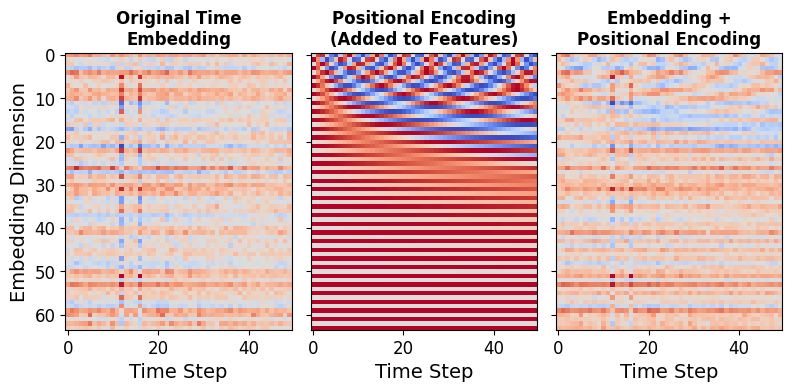

In [ ]:
# ------------------------------
# Positional Encoding Visualization
# ------------------------------

# Load data
X = np.load(f'{file_path}transformer/FD001_X_augmented.npy')
sample = X[np.random.randint(0, len(X))][None, :, :]

# Embedding
conv1d = layers.Conv1D(64, 1, padding='same')
time_embed = conv1d(sample).numpy().squeeze()

# Positional Encoding
pos_encoding = get_positional_encoding(sample.shape[1], 64).numpy().squeeze()

# Add positional encoding to the embedding
time_embed_with_pos = time_embed + pos_encoding

# Plot
fig, axs = plt.subplots(1, 3, figsize=(8, 4))
titles = ['Original Time\nEmbedding',
          'Positional Encoding\n(Added to Features)',
          'Embedding +\nPositional Encoding']
data = [time_embed.T, pos_encoding.T, time_embed_with_pos.T]

for i, (ax, d, title) in enumerate(zip(axs, data, titles)):
    ax.imshow(d, aspect='auto', cmap='coolwarm')
    ax.set_xlabel('Time Step', fontsize=14)
    if i == 0:
        ax.set_ylabel('Embedding Dimension', fontsize=14)
    else:
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.tick_params(axis='both', labelsize=12)

plt.tight_layout(pad=1.0)
plt.savefig('positional_encoding_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


## Model evaluation

This code block defines all functions for compiling, training, and evaluating the model.

- **compile_and_train**: this compiles the model using Adam as an optimizer. **Adam** is chosen due to its inbuilt momemtum for smoother and faster updates and its adaptive learning rate. Moreover, we use **Early Stopping** to end the training prematurely if no improvement in validation loss is recorded. Finally, the **Learning Rate Scheduler** allows us to avoid oscillation on plateaus by reducing the learning rate if there is no decrease in validation loss after the number of epochs specified in patience. The function also plots training and validation RMSE to verify that the training procedure is successful.

**Important Note:** due to the strong use of dropout in our model definition, it is already expected that the validation loss may run below the training loss.

- **RMSE:** definition of the root mean squared error, the primary evaluation metric in the literature on RUL prediction.

- **PHM Score:** definition of PHM (Prognostics and Health Management Score), the secondary evaluation metric in the literature, where over-prediction is punished more than underprediction.

- **evaluate_model:** this now calculates the two evaluation metrics on the test set and generates a scatter plot of true RUL value vs predicted RUL value. A 45-degree line is added to designate where the points would lie in an ideal scenario.

In [ ]:
# ------------------------------
# Training and Evaluation Utils
# ------------------------------

# Asymmetric MSE to penalise over-prediction of RUL more
# (not used in the final report but left here as an example extension)
def asymmetric_mse(y_true, y_pred):
    error = y_pred - y_true
    under = tf.square(error) * tf.cast(error < 0, tf.float32)
    over = tf.square(error) * tf.cast(error >= 0, tf.float32) * 2
    return tf.reduce_mean(under + over)

def compile_and_train(model, X_train, y_train, X_val, y_val, save_dir, name="unknown", loss='mse'):
    # Compile model
    model.compile(
        optimizer='adam',
        loss=[loss],
        metrics=[RootMeanSquaredError(name='rmse'), None]
    )
    # Callbacks
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, restore_best_weights=True),
    lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    # Fit the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=n_epochs,
        batch_size=batch_size,
        callbacks=[es, lr]
    )

    # Plot Training and Validation RMSE per Epoch
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
    ax1.plot(history.history['rmse'])
    ax1.plot(history.history['val_rmse'])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('RMSE')
    ax1.legend(['Train', 'Validation'])
    ax1.set_title(f'RUL Prediction Loss (RMSE) - {name}')
    plt.savefig(f'{save_dir}/rul_rmse_plot_{name}.png')
    plt.show()
    return history

def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

def phm_score(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        if pred > true:
            score = np.exp(np.abs(pred - true) / 13) - 1
        else:
            score = np.exp(np.abs(pred - true) / 10) - 1
        scores.append(score)
    return np.sum(scores)

def evaluate_model(model, test_data, save_dir, name="unknown"):
    X_test = test_data['X_test']
    y_test = test_data['y_test']

    # 1. Predict RUL on unseen test data
    y_pred = model.predict(X_test).flatten()
    y_pred = y_pred.flatten()

    # 2. Evaluate
    rmse_score = rmse(y_test, y_pred)
    phm = phm_score(y_test, y_pred)

    print(f"RMSE: {rmse_score:.2f}")
    print(f"PHM Score: {phm:.2f}")

    # Plot
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.xlabel('Actual RUL')
    plt.ylabel('Predicted RUL')
    plt.grid(True)
    plt.title(f'Actual vs Predicted RUL - {name}')
    plt.savefig(f'{save_dir}/Actual_vs_pred_RUL{name}.png')
    plt.show()
    return rmse_score, phm

## Training pipeline

This section defines the training and evaluation pipeline that is then used with our model on all four datasets. The pipeline uses five-fold cross-validation to reduce the reliance on any specific train-val split and therefore increase the degree to which our model can generalise to new and unseen data.

In [ ]:
# ------------------------------
# Defining the training and evaluation pipeline
# ------------------------------

dataset_names = ["FD001", "FD002", "FD003", "FD004"]

def pipeline(dataset_names, base_path, loss='mse', n_splits=5):
    results = {}

    for name in dataset_names:
        X = np.load(f'{base_path}/{name}_X_augmented.npy')
        y = np.load(f'{base_path}/{name}_y_augmented.npy')
        test_data = np.load(f'{base_path}/{name}_test_windows.npz')

        y[y >= 130] = 130

        # Cross-validation
        cv_scores = []
        kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        y_bins = np.floor(y / 10).astype(int)

        for train_idx, val_idx in kfold.split(X, y_bins):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            input_shape = X_train.shape[1:]
            model = build_enhanced_dast_model(input_shape)
            history = compile_and_train(model, X_train, y_train, X_val, y_val, name=name, save_dir=save_dir, loss=loss)

            y_val_pred = model.predict(X_val).flatten()
            fold_rmse = rmse(y_val, y_val_pred)
            cv_scores.append(fold_rmse)

            del model
            K.clear_session()
            gc.collect()

        avg_cv_rmse = np.mean(cv_scores)

        # Final model training on full data
        input_shape = X.shape[1:]
        final_model = build_enhanced_dast_model(input_shape)
        history = compile_and_train(final_model, X, y, X, y, name=name, save_dir=save_dir, loss=loss)

        # Predict on test set
        y_test = test_data['y_test']
        X_test = test_data['X_test']
        y_pred = final_model.predict(X_test).flatten()
        final_rmse = rmse(y_test, y_pred)
        final_phm = phm_score(y_test, y_pred)

        results[name] = {
            'CV_RMSE': avg_cv_rmse,
            'Final_RMSE': final_rmse,
            'PHM': final_phm,
            'actual': y_test,
            'final_preds': y_pred
        }

        del final_model
        K.clear_session()
        gc.collect()

    return results

In [ ]:
# ------------------------------
# Final grid of dispersion plots
# ------------------------------

def plot_dispersion_grid(results, save_dir):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.tight_layout(pad=5.0)

    for i, name in enumerate(results):
        y_test = results[name]['actual']
        y_pred = results[name]['final_preds']
        rmse_score = results[name]['Final_RMSE']
        phm = results[name]['PHM']

        ax = axes[i // 2, i % 2]
        ax.scatter(y_test, y_pred, alpha=0.6)
        mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
        ax.plot([mn, mx], [mn, mx], 'r--')
        ax.set_title(f"{name}\nRMSE: {rmse_score:.2f}, PHM: {phm:.2f}", fontsize=13)
        ax.set_xlabel('Actual RUL')
        ax.set_ylabel('Predicted RUL')
        ax.grid(True)

    plt.savefig(f'{save_dir}/All_Plots_Actual_vs_Predicted_RUL.png')
    plt.show()


Epoch 1/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 96s 149ms/step - loss: 6232.6616 - rmse: 78.9128 - val_loss: 3266.4517 - val_rmse: 57.1529 - learning_rate: 0.0010
Epoch 2/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3519.5945 - rmse: 59.2402 - val_loss: 1926.4558 - val_rmse: 43.8914 - learning_rate: 0.0010
Epoch 3/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1114.2510 - rmse: 33.2427 - val_loss: 139.5767 - val_rmse: 11.8143 - learning_rate: 0.0010
Epoch 4/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 282.9466 - rmse: 16.8042 - val_loss: 950.5637 - val_rmse: 30.8312 - learning_rate: 0.0010
Epoch 5/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 213.3045 - rmse: 14.6034 - val_loss: 78.9555 - val_rmse: 8.8857 - learning_rate: 0.0010
Epoch 6/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 190.6386 - rmse: 13.8060 - val_loss: 94.9136 - val_rmse: 9.7424 - learning_rate: 0.0010
Epoch 7/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 189.8405 - rmse: 13.7707 - va

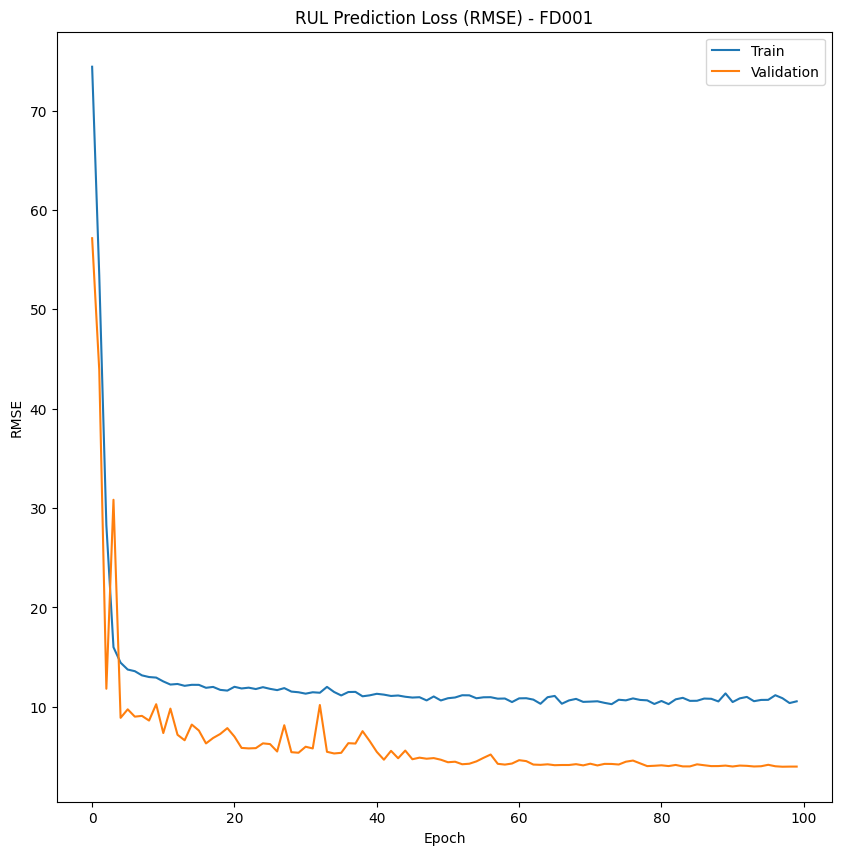

80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step
Epoch 1/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 53s 72ms/step - loss: 6168.3486 - rmse: 78.4971 - val_loss: 5746.6787 - val_rmse: 75.8069 - learning_rate: 0.0010
Epoch 2/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3448.5713 - rmse: 58.6519 - val_loss: 1649.4279 - val_rmse: 40.6131 - learning_rate: 0.0010
Epoch 3/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1143.1332 - rmse: 33.5711 - val_loss: 730.2995 - val_rmse: 27.0241 - learning_rate: 0.0010
Epoch 4/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 272.0771 - rmse: 16.4833 - val_loss: 109.4240 - val_rmse: 10.4606 - learning_rate: 0.0010
Epoch 5/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 206.8121 - rmse: 14.3784 - val_loss: 228.2470 - val_rmse: 15.1078 - learning_rate: 0.0010
Epoch 6/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 202.5659 - rmse: 14.2301 - val_loss: 225.1159 - val_rmse: 15.0039 - learning_rate: 0.0010
Epoch 7/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms

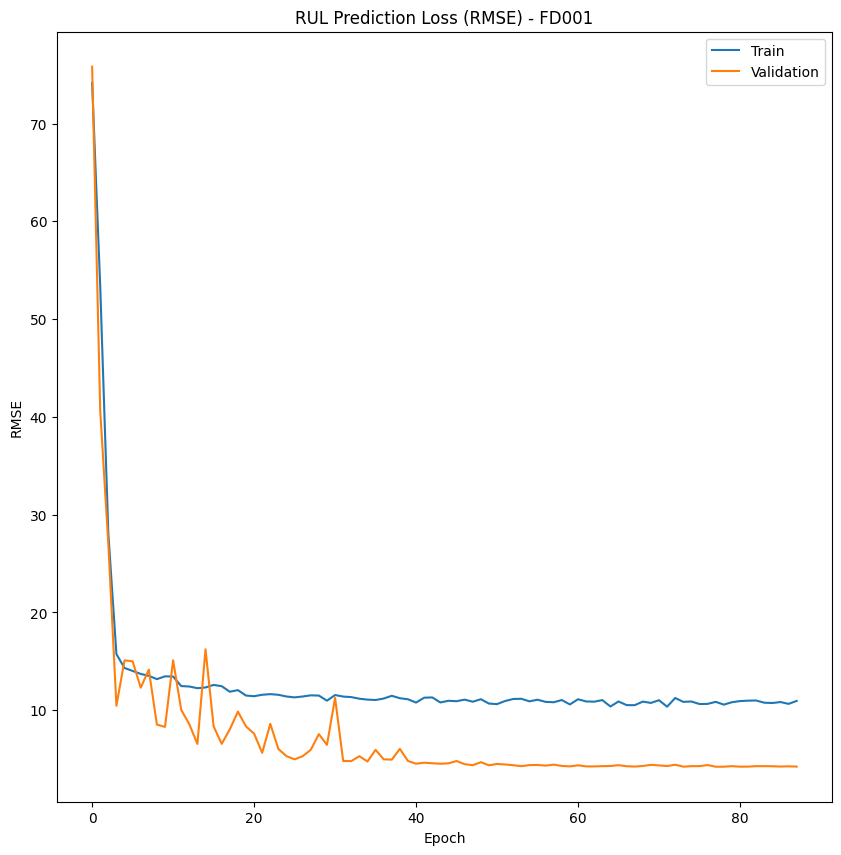

80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step
Epoch 1/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 53s 71ms/step - loss: 6196.6763 - rmse: 78.6745 - val_loss: 12709.1074 - val_rmse: 112.7347 - learning_rate: 0.0010
Epoch 2/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3497.8889 - rmse: 59.0525 - val_loss: 2652.7878 - val_rmse: 51.5052 - learning_rate: 0.0010
Epoch 3/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1118.7911 - rmse: 33.2678 - val_loss: 573.3228 - val_rmse: 23.9442 - learning_rate: 0.0010
Epoch 4/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 306.1711 - rmse: 17.4775 - val_loss: 89.0883 - val_rmse: 9.4387 - learning_rate: 0.0010
Epoch 5/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 232.5890 - rmse: 15.2447 - val_loss: 226.5157 - val_rmse: 15.0504 - learning_rate: 0.0010
Epoch 6/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 214.6962 - rmse: 14.6441 - val_loss: 210.3368 - val_rmse: 14.5030 - learning_rate: 0.0010
Epoch 7/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms

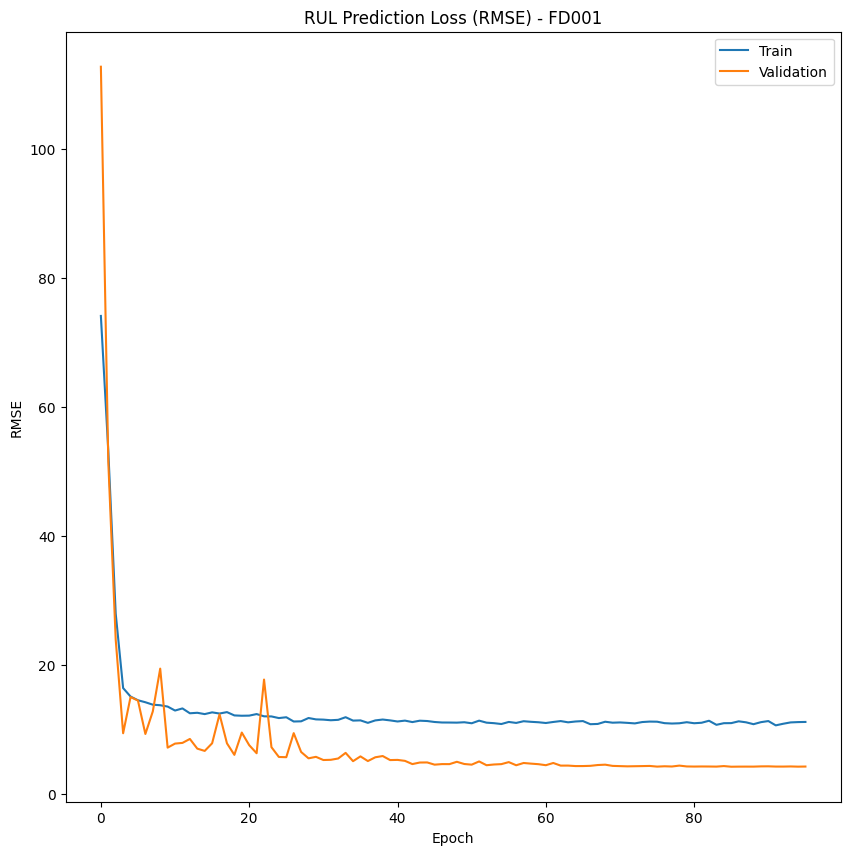

80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step
Epoch 1/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 54s 74ms/step - loss: 6303.4937 - rmse: 79.3391 - val_loss: 1756.4458 - val_rmse: 41.9100 - learning_rate: 0.0010
Epoch 2/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3548.1296 - rmse: 59.4523 - val_loss: 1890.3151 - val_rmse: 43.4778 - learning_rate: 0.0010
Epoch 3/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1109.1166 - rmse: 33.1422 - val_loss: 216.9411 - val_rmse: 14.7289 - learning_rate: 0.0010
Epoch 4/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 287.2395 - rmse: 16.9094 - val_loss: 111.4021 - val_rmse: 10.5547 - learning_rate: 0.0010
Epoch 5/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 208.1043 - rmse: 14.4241 - val_loss: 142.8842 - val_rmse: 11.9534 - learning_rate: 0.0010
Epoch 6/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 196.7981 - rmse: 14.0237 - val_loss: 86.9918 - val_rmse: 9.3269 - learning_rate: 0.0010
Epoch 7/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/s

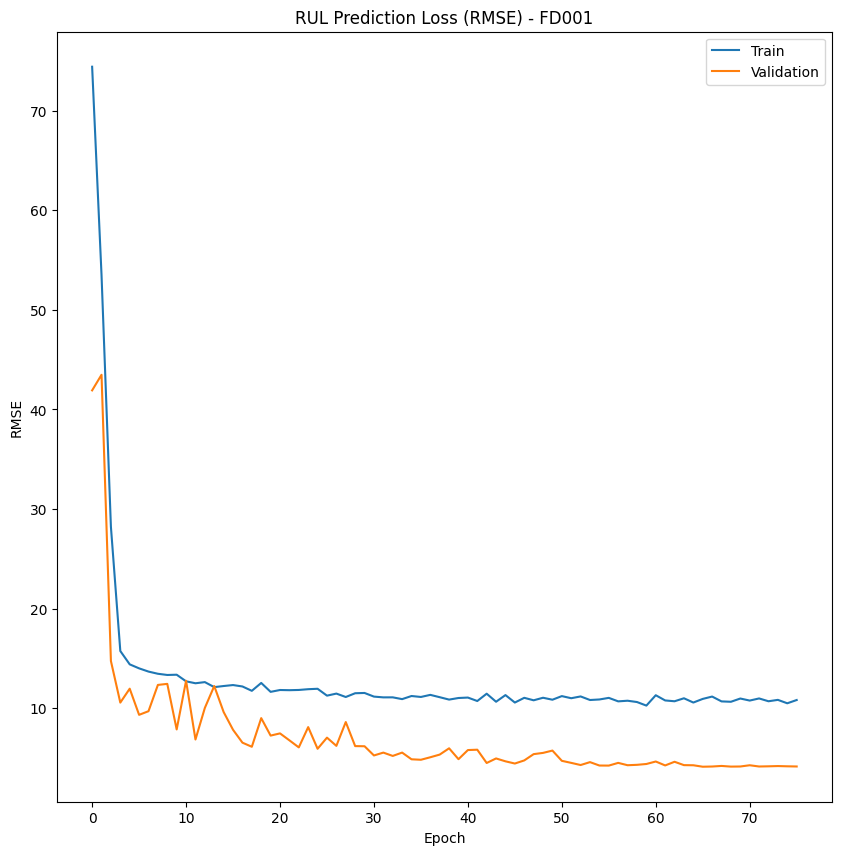

80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step
Epoch 1/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 70s 124ms/step - loss: 6272.5103 - rmse: 79.1529 - val_loss: 6767.9458 - val_rmse: 82.2675 - learning_rate: 0.0010
Epoch 2/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3569.3623 - rmse: 59.6429 - val_loss: 399.4763 - val_rmse: 19.9869 - learning_rate: 0.0010
Epoch 3/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1151.6376 - rmse: 33.7599 - val_loss: 2413.0354 - val_rmse: 49.1227 - learning_rate: 0.0010
Epoch 4/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 287.3017 - rmse: 16.9283 - val_loss: 288.2534 - val_rmse: 16.9780 - learning_rate: 0.0010
Epoch 5/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 211.3307 - rmse: 14.5031 - val_loss: 452.7742 - val_rmse: 21.2785 - learning_rate: 0.0010
Epoch 6/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 193.1704 - rmse: 13.8961 - val_loss: 116.4864 - val_rmse: 10.7929 - learning_rate: 0.0010
Epoch 7/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 8m

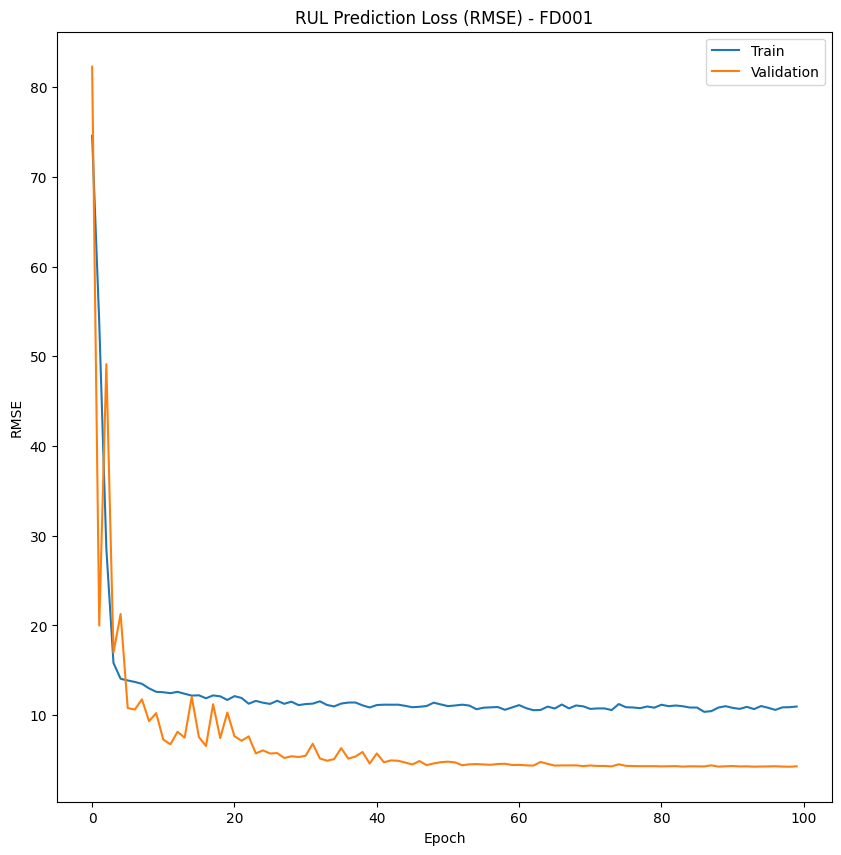

80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step
Epoch 1/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 70s 99ms/step - loss: 6026.1523 - rmse: 77.5647 - val_loss: 3370.2344 - val_rmse: 58.0537 - learning_rate: 0.0010
Epoch 2/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2662.3857 - rmse: 51.4357 - val_loss: 257.2103 - val_rmse: 16.0378 - learning_rate: 0.0010
Epoch 3/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 455.9093 - rmse: 21.2591 - val_loss: 267.3438 - val_rmse: 16.3507 - learning_rate: 0.0010
Epoch 4/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 215.0639 - rmse: 14.6640 - val_loss: 129.2110 - val_rmse: 11.3671 - learning_rate: 0.0010
Epoch 5/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 215.7945 - rmse: 14.6748 - val_loss: 165.4099 - val_rmse: 12.8612 - learning_rate: 0.0010
Epoch 6/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 202.6513 - rmse: 14.2302 - val_loss: 220.7522 - val_rmse: 14.8577 - learning_rate: 0.0010
Epoch 7/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 10m

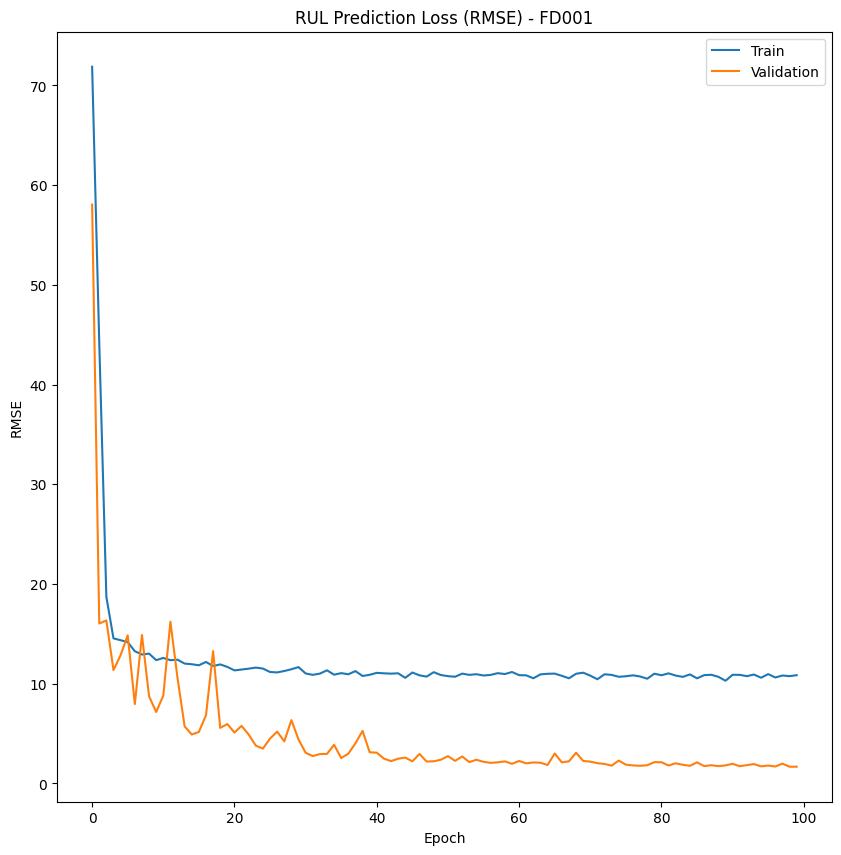

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step
Epoch 1/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 86s 58ms/step - loss: 6417.4473 - rmse: 79.7570 - val_loss: 1137.9708 - val_rmse: 33.7338 - learning_rate: 0.0010
Epoch 2/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 494.0430 - rmse: 22.0677 - val_loss: 142.5725 - val_rmse: 11.9404 - learning_rate: 0.0010
Epoch 3/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 274.2290 - rmse: 16.5580 - val_loss: 132.7410 - val_rmse: 11.5213 - learning_rate: 0.0010
Epoch 4/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 259.2177 - rmse: 16.0995 - val_loss: 138.9914 - val_rmse: 11.7895 - learning_rate: 0.0010
Epoch 5/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 241.7098 - rmse: 15.5454 - val_loss: 120.9388 - val_rmse: 10.9972 - learning_rate: 0.0010
Epoch 6/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 242.7628 - rmse: 15.5781 - val_loss: 105.9558 - val_rmse: 10.2935 - learning_rate: 0.0010
Epoch 7/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step 

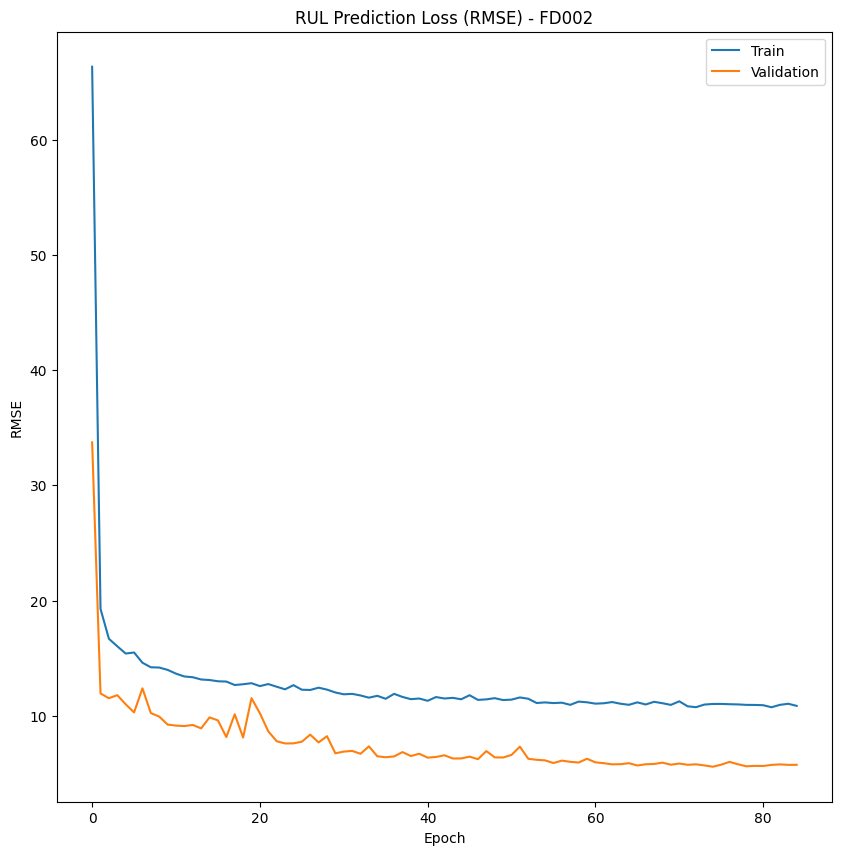

208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
Epoch 1/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 57s 32ms/step - loss: 6359.7412 - rmse: 79.4188 - val_loss: 328.7292 - val_rmse: 18.1309 - learning_rate: 0.0010
Epoch 2/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 489.7200 - rmse: 21.9764 - val_loss: 140.0937 - val_rmse: 11.8361 - learning_rate: 0.0010
Epoch 3/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 267.9627 - rmse: 16.3674 - val_loss: 130.4862 - val_rmse: 11.4231 - learning_rate: 0.0010
Epoch 4/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 264.2308 - rmse: 16.2544 - val_loss: 228.3578 - val_rmse: 15.1115 - learning_rate: 0.0010
Epoch 5/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 249.1695 - rmse: 15.7845 - val_loss: 298.2091 - val_rmse: 17.2687 - learning_rate: 0.0010
Epoch 6/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 222.9419 - rmse: 14.9304 - val_loss: 154.2439 - val_rmse: 12.4195 - learning_rate: 0.0010
Epoch 7/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/s

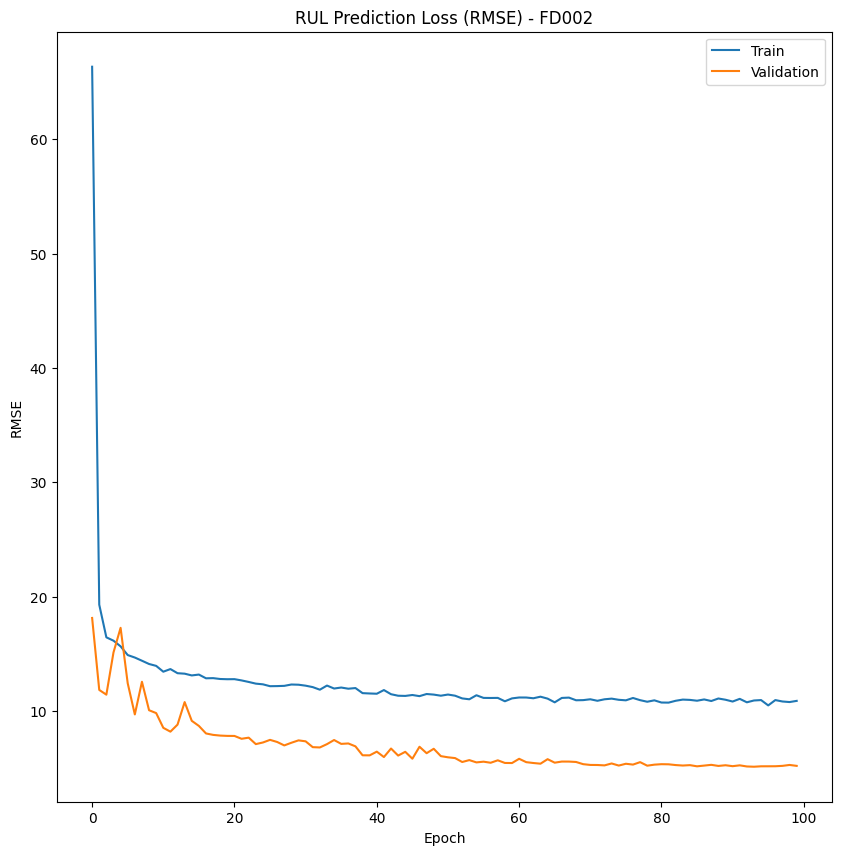

208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step
Epoch 1/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 75s 53ms/step - loss: 6335.7490 - rmse: 79.2522 - val_loss: 645.8795 - val_rmse: 25.4142 - learning_rate: 0.0010
Epoch 2/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 481.5739 - rmse: 21.8064 - val_loss: 138.2271 - val_rmse: 11.7570 - learning_rate: 0.0010
Epoch 3/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 284.3423 - rmse: 16.8607 - val_loss: 167.1389 - val_rmse: 12.9282 - learning_rate: 0.0010
Epoch 4/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 254.7001 - rmse: 15.9587 - val_loss: 137.3261 - val_rmse: 11.7186 - learning_rate: 0.0010
Epoch 5/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 239.5154 - rmse: 15.4751 - val_loss: 125.5236 - val_rmse: 11.2037 - learning_rate: 0.0010
Epoch 6/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 220.1933 - rmse: 14.8384 - val_loss: 107.7927 - val_rmse: 10.3823 - learning_rate: 0.0010
Epoch 7/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/s

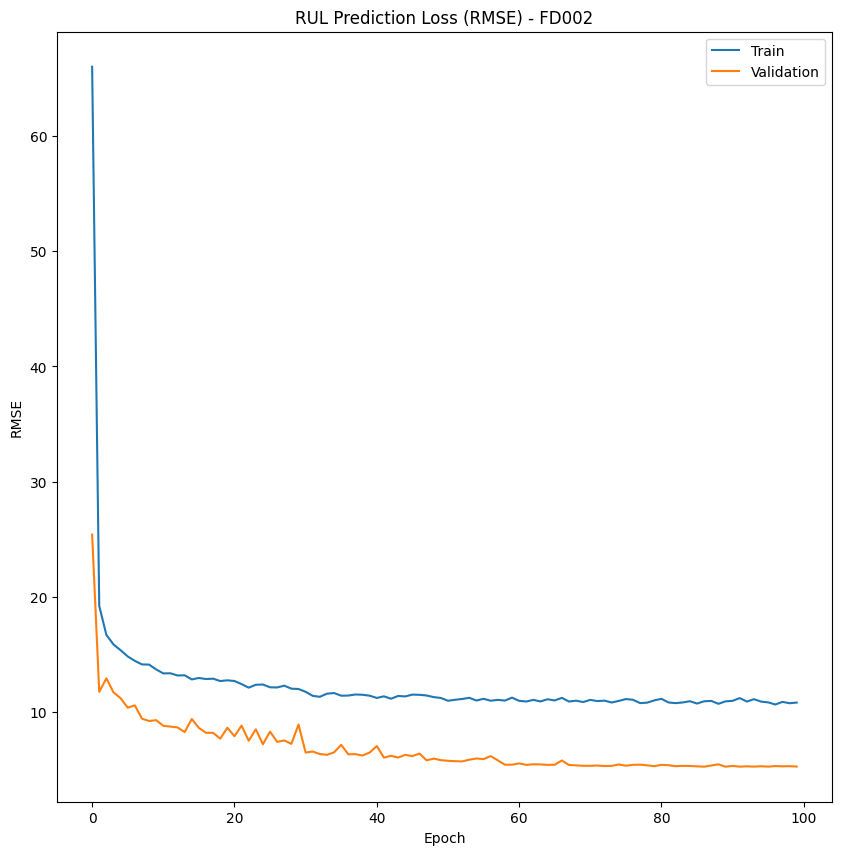

208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
Epoch 1/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 57s 32ms/step - loss: 6319.4741 - rmse: 79.1531 - val_loss: 434.2807 - val_rmse: 20.8394 - learning_rate: 0.0010
Epoch 2/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 483.3887 - rmse: 21.8711 - val_loss: 235.6644 - val_rmse: 15.3514 - learning_rate: 0.0010
Epoch 3/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 286.9484 - rmse: 16.9384 - val_loss: 227.3346 - val_rmse: 15.0776 - learning_rate: 0.0010
Epoch 4/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 262.1522 - rmse: 16.1897 - val_loss: 176.5293 - val_rmse: 13.2864 - learning_rate: 0.0010
Epoch 5/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 244.5781 - rmse: 15.6379 - val_loss: 123.5174 - val_rmse: 11.1138 - learning_rate: 0.0010
Epoch 6/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 241.2659 - rmse: 15.5304 - val_loss: 94.7517 - val_rmse: 9.7340 - learning_rate: 0.0010
Epoch 7/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/ste

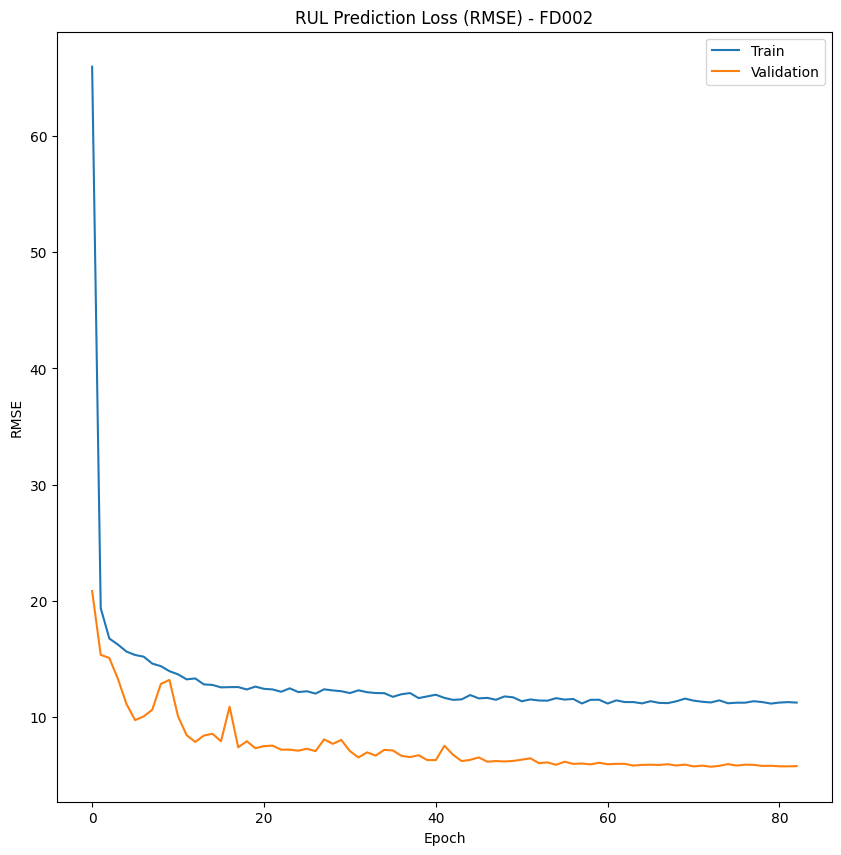

208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
Epoch 1/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 58s 33ms/step - loss: 6418.0410 - rmse: 79.7563 - val_loss: 290.4845 - val_rmse: 17.0436 - learning_rate: 0.0010
Epoch 2/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 481.5500 - rmse: 21.8357 - val_loss: 149.7803 - val_rmse: 12.2385 - learning_rate: 0.0010
Epoch 3/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 291.1489 - rmse: 17.0614 - val_loss: 127.5700 - val_rmse: 11.2947 - learning_rate: 0.0010
Epoch 4/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 256.7257 - rmse: 16.0214 - val_loss: 123.0640 - val_rmse: 11.0934 - learning_rate: 0.0010
Epoch 5/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 248.4380 - rmse: 15.7576 - val_loss: 121.5324 - val_rmse: 11.0242 - learning_rate: 0.0010
Epoch 6/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 231.4579 - rmse: 15.2088 - val_loss: 200.4083 - val_rmse: 14.1566 - learning_rate: 0.0010
Epoch 7/100
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/s

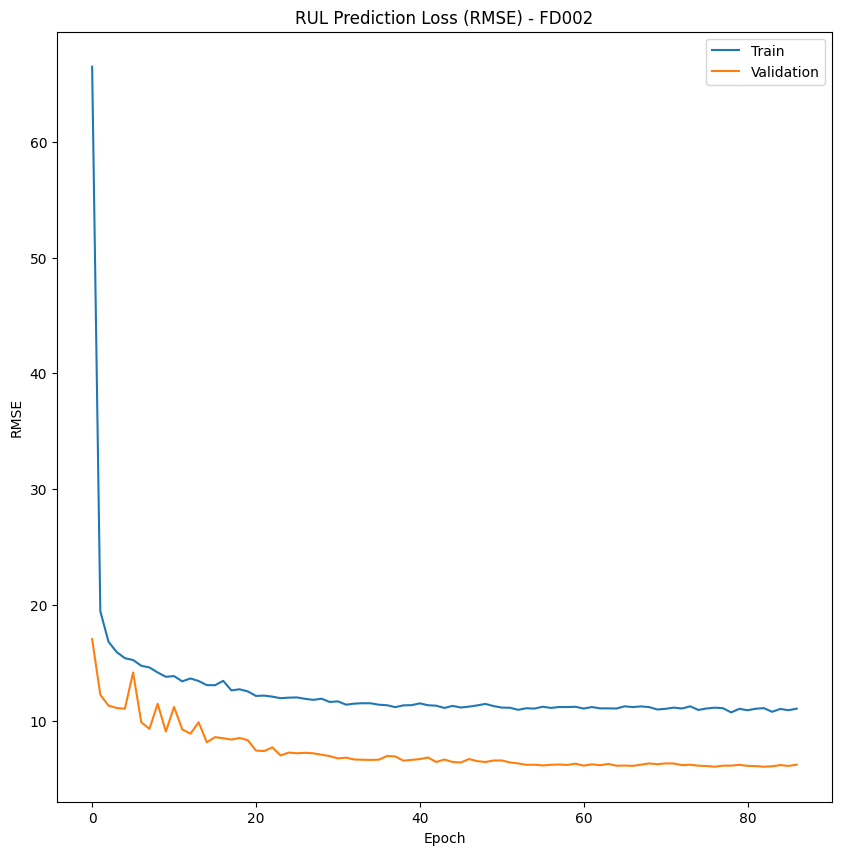

208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
Epoch 1/100
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 67s 35ms/step - loss: 5880.8394 - rmse: 76.0850 - val_loss: 183.0561 - val_rmse: 13.5298 - learning_rate: 0.0010
Epoch 2/100
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 315.7766 - rmse: 17.7662 - val_loss: 153.1168 - val_rmse: 12.3740 - learning_rate: 0.0010
Epoch 3/100
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 259.8093 - rmse: 16.1179 - val_loss: 123.2136 - val_rmse: 11.1002 - learning_rate: 0.0010
Epoch 4/100
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 250.7646 - rmse: 15.8342 - val_loss: 103.9554 - val_rmse: 10.1959 - learning_rate: 0.0010
Epoch 5/100
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 237.7362 - rmse: 15.4181 - val_loss: 97.5957 - val_rmse: 9.8791 - learning_rate: 0.0010
Epoch 6/100
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 215.9934 - rmse: 14.6960 - val_loss: 67.1622 - val_rmse: 8.1953 - learning_rate: 0.0010
Epoch 7/100
1038/1038 ━━━━━━━━━━

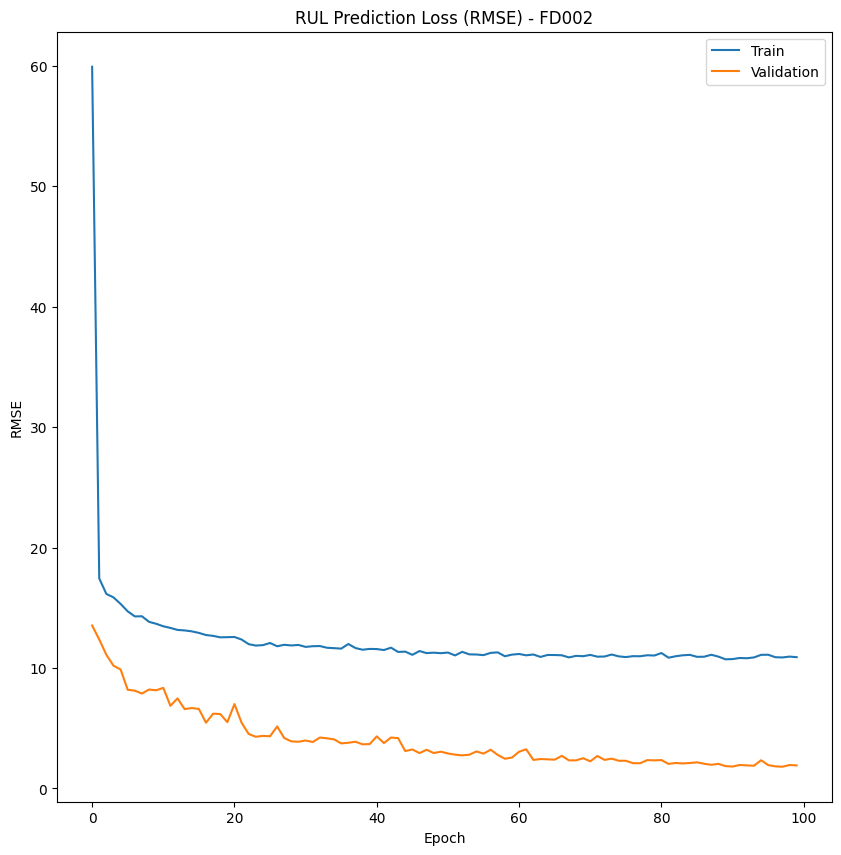

9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Epoch 1/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 64s 84ms/step - loss: 7461.4463 - rmse: 86.3190 - val_loss: 1876.1488 - val_rmse: 43.3145 - learning_rate: 0.0010
Epoch 2/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3534.1736 - rmse: 59.2714 - val_loss: 1614.6207 - val_rmse: 40.1823 - learning_rate: 0.0010
Epoch 3/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 643.2219 - rmse: 25.1866 - val_loss: 248.9152 - val_rmse: 15.7770 - learning_rate: 0.0010
Epoch 4/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 244.0149 - rmse: 15.6146 - val_loss: 83.9345 - val_rmse: 9.1616 - learning_rate: 0.0010
Epoch 5/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 220.1205 - rmse: 14.8345 - val_loss: 169.2569 - val_rmse: 13.0099 - learning_rate: 0.0010
Epoch 6/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 208.2925 - rmse: 14.4276 - val_loss: 87.0900 - val_rmse: 9.3322 - learning_rate: 0.0010
Epoch 7/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - 

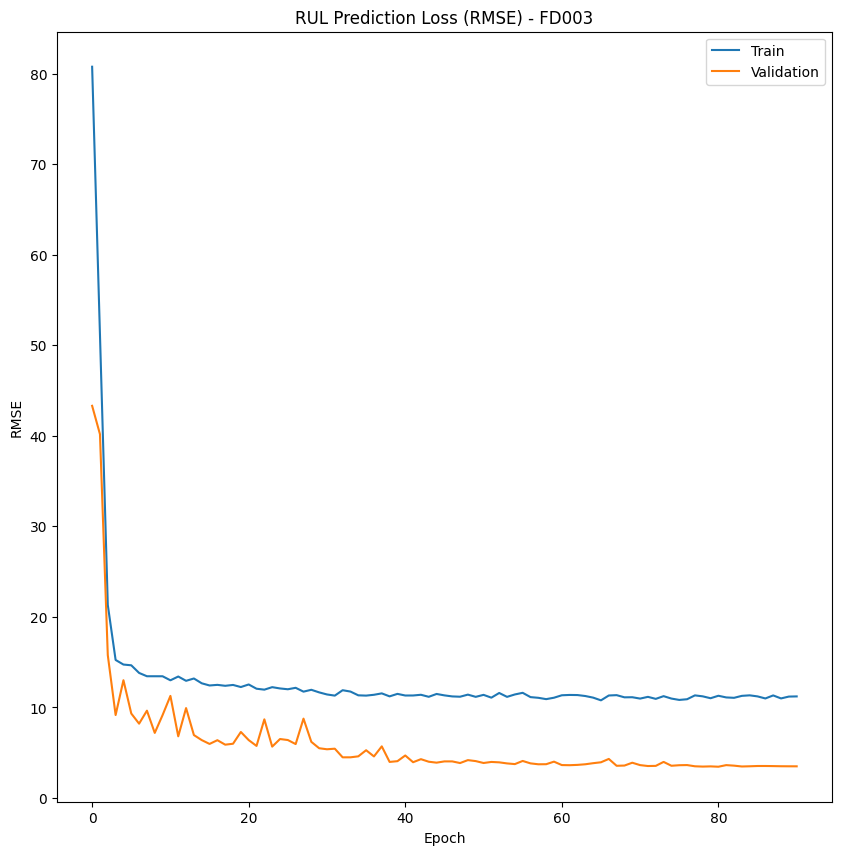

101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step
Epoch 1/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 54s 57ms/step - loss: 7459.1211 - rmse: 86.2979 - val_loss: 3074.1021 - val_rmse: 55.4446 - learning_rate: 0.0010
Epoch 2/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3514.0745 - rmse: 59.1065 - val_loss: 1191.8348 - val_rmse: 34.5230 - learning_rate: 0.0010
Epoch 3/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 643.8661 - rmse: 25.1854 - val_loss: 126.4965 - val_rmse: 11.2471 - learning_rate: 0.0010
Epoch 4/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 259.1695 - rmse: 16.0847 - val_loss: 140.0557 - val_rmse: 11.8345 - learning_rate: 0.0010
Epoch 5/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 221.3159 - rmse: 14.8745 - val_loss: 77.0222 - val_rmse: 8.7762 - learning_rate: 0.0010
Epoch 6/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 210.9137 - rmse: 14.5206 - val_loss: 77.5531 - val_rmse: 8.8064 - learning_rate: 0.0010
Epoch 7/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/st

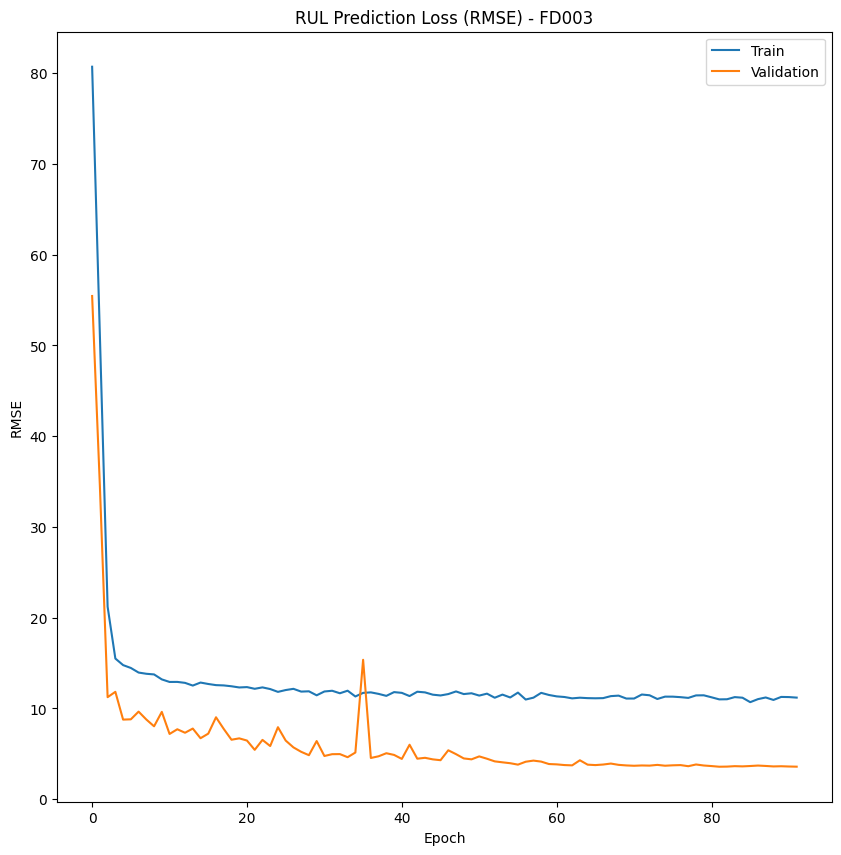

101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step
Epoch 1/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 55s 59ms/step - loss: 7532.0337 - rmse: 86.7272 - val_loss: 2971.1401 - val_rmse: 54.5082 - learning_rate: 0.0010
Epoch 2/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3584.6882 - rmse: 59.6864 - val_loss: 1004.0361 - val_rmse: 31.6865 - learning_rate: 0.0010
Epoch 3/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 650.3573 - rmse: 25.3028 - val_loss: 84.4038 - val_rmse: 9.1872 - learning_rate: 0.0010
Epoch 4/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 233.9461 - rmse: 15.2934 - val_loss: 88.8452 - val_rmse: 9.4258 - learning_rate: 0.0010
Epoch 5/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 210.5289 - rmse: 14.5080 - val_loss: 75.2526 - val_rmse: 8.6748 - learning_rate: 0.0010
Epoch 6/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 209.9807 - rmse: 14.4824 - val_loss: 133.3365 - val_rmse: 11.5471 - learning_rate: 0.0010
Epoch 7/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

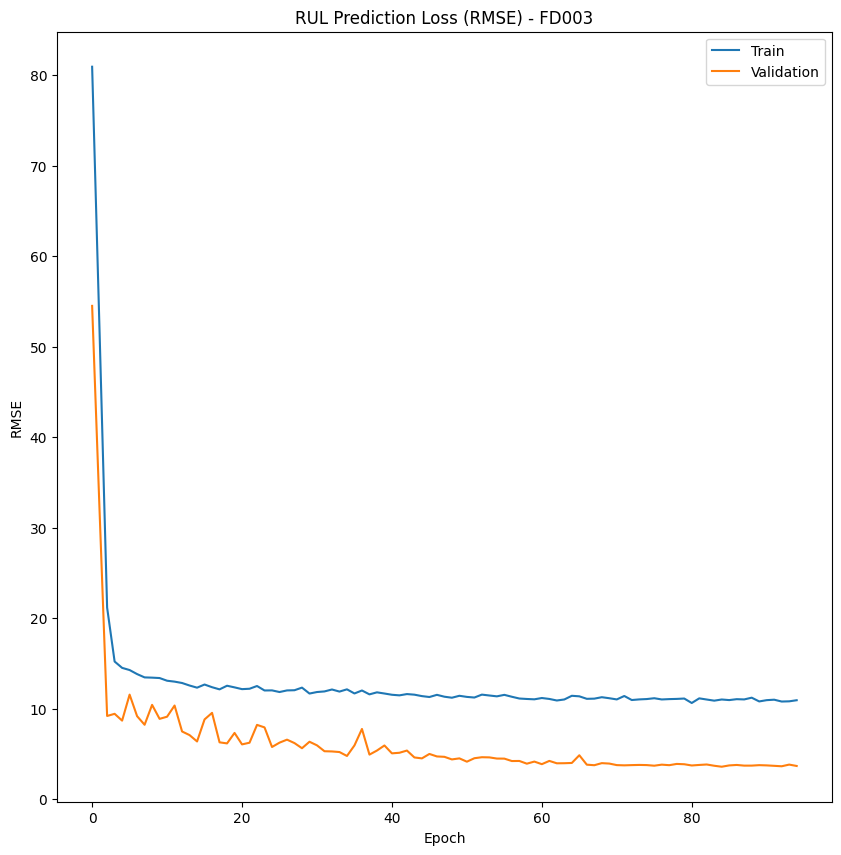

101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step
Epoch 1/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 55s 60ms/step - loss: 7481.0537 - rmse: 86.4306 - val_loss: 3525.1636 - val_rmse: 59.3731 - learning_rate: 0.0010
Epoch 2/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3586.0972 - rmse: 59.6730 - val_loss: 669.2446 - val_rmse: 25.8698 - learning_rate: 0.0010
Epoch 3/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 639.3614 - rmse: 25.1329 - val_loss: 93.6747 - val_rmse: 9.6786 - learning_rate: 0.0010
Epoch 4/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 228.1644 - rmse: 15.1013 - val_loss: 264.5989 - val_rmse: 16.2665 - learning_rate: 0.0010
Epoch 5/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 218.1815 - rmse: 14.7697 - val_loss: 70.3049 - val_rmse: 8.3848 - learning_rate: 0.0010
Epoch 6/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 205.2585 - rmse: 14.3247 - val_loss: 69.2112 - val_rmse: 8.3193 - learning_rate: 0.0010
Epoch 7/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step 

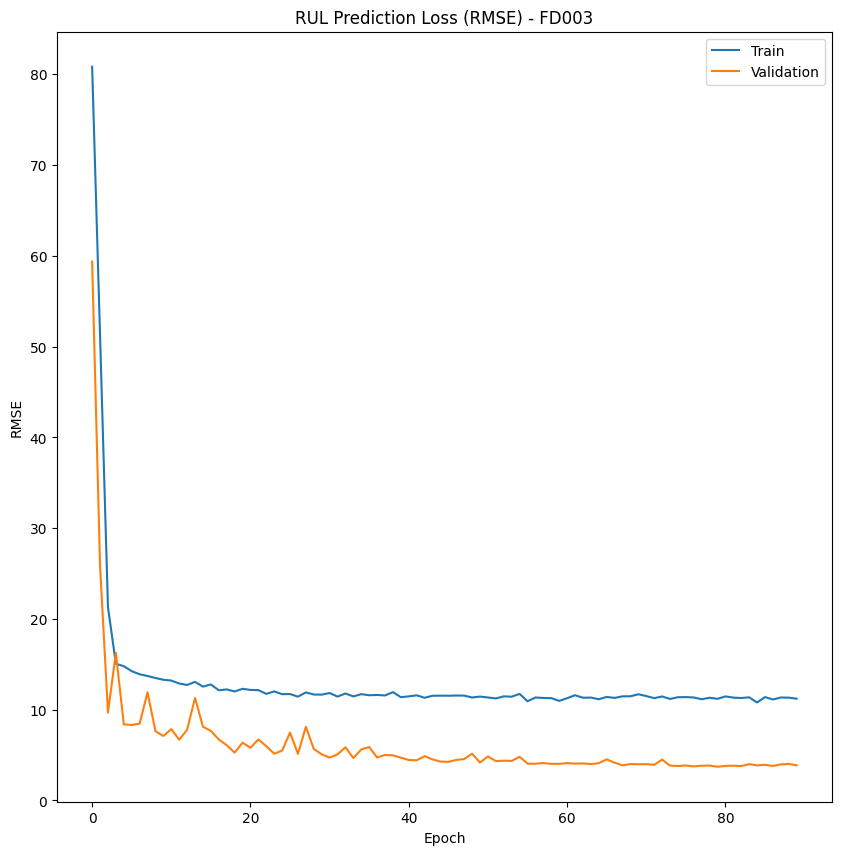

101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step
Epoch 1/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 61s 74ms/step - loss: 7444.4863 - rmse: 86.2240 - val_loss: 5148.1445 - val_rmse: 71.7506 - learning_rate: 0.0010
Epoch 2/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3617.8174 - rmse: 59.9107 - val_loss: 1274.4913 - val_rmse: 35.7000 - learning_rate: 0.0010
Epoch 3/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 642.6661 - rmse: 25.1780 - val_loss: 92.4129 - val_rmse: 9.6132 - learning_rate: 0.0010
Epoch 4/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 235.6123 - rmse: 15.3478 - val_loss: 83.0634 - val_rmse: 9.1139 - learning_rate: 0.0010
Epoch 5/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 218.7841 - rmse: 14.7903 - val_loss: 121.1763 - val_rmse: 11.0080 - learning_rate: 0.0010
Epoch 6/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 204.8396 - rmse: 14.3022 - val_loss: 62.4180 - val_rmse: 7.9005 - learning_rate: 0.0010
Epoch 7/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

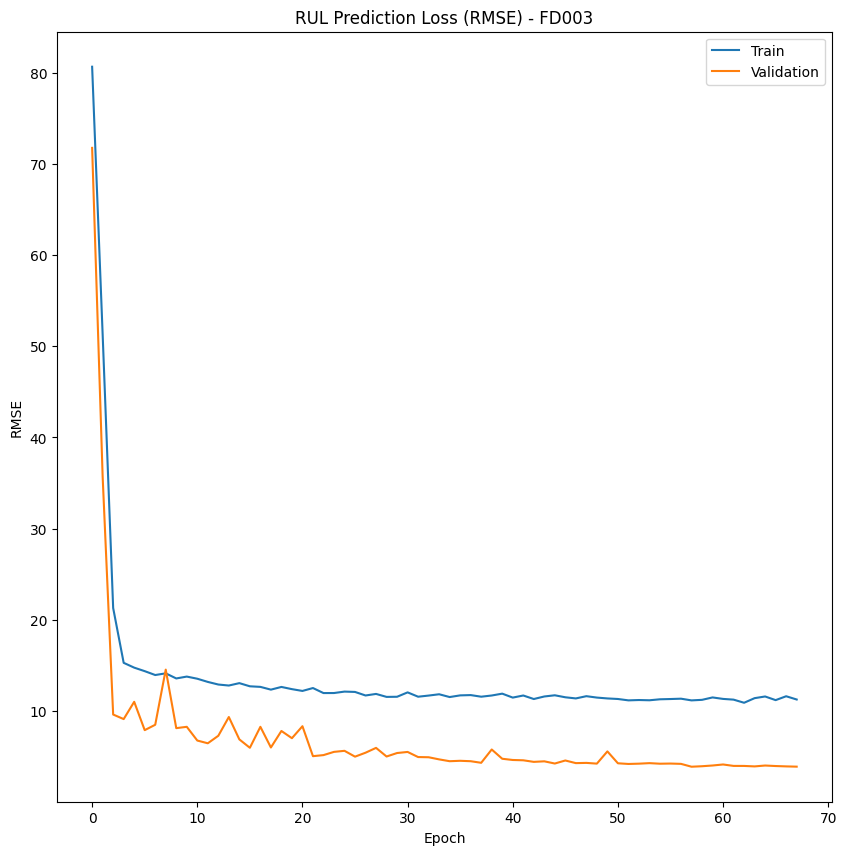

101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step
Epoch 1/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 72s 84ms/step - loss: 7184.5649 - rmse: 84.6512 - val_loss: 3653.4937 - val_rmse: 60.4441 - learning_rate: 0.0010
Epoch 2/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2413.8186 - rmse: 48.6865 - val_loss: 208.0493 - val_rmse: 14.4239 - learning_rate: 0.0010
Epoch 3/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 284.2381 - rmse: 16.8332 - val_loss: 61.9756 - val_rmse: 7.8725 - learning_rate: 0.0010
Epoch 4/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 213.2689 - rmse: 14.6014 - val_loss: 55.6449 - val_rmse: 7.4596 - learning_rate: 0.0010
Epoch 5/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 217.3978 - rmse: 14.7433 - val_loss: 79.3922 - val_rmse: 8.9102 - learning_rate: 0.0010
Epoch 6/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 201.2974 - rmse: 14.1858 - val_loss: 50.5937 - val_rmse: 7.1129 - learning_rate: 0.0010
Epoch 7/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step -

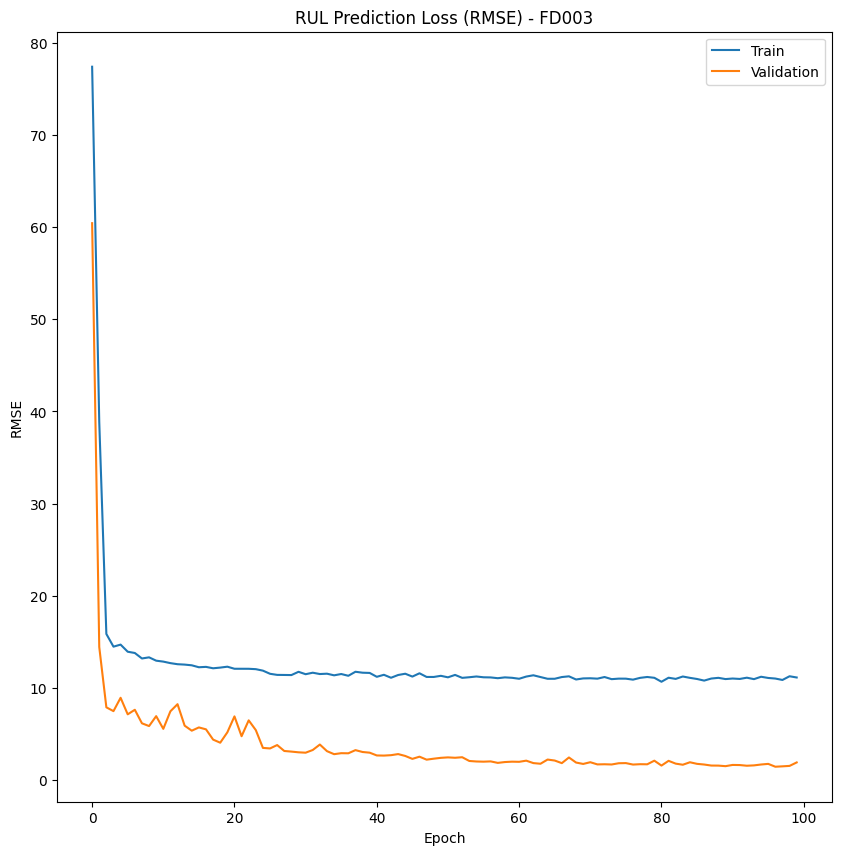

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 891ms/step
Epoch 1/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 70s 39ms/step - loss: 6704.4551 - rmse: 81.3875 - val_loss: 314.4645 - val_rmse: 17.7331 - learning_rate: 0.0010
Epoch 2/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 387.8422 - rmse: 19.6612 - val_loss: 539.1588 - val_rmse: 23.2198 - learning_rate: 0.0010
Epoch 3/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 283.6602 - rmse: 16.8415 - val_loss: 188.3179 - val_rmse: 13.7229 - learning_rate: 0.0010
Epoch 4/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 265.6794 - rmse: 16.2979 - val_loss: 130.8639 - val_rmse: 11.4396 - learning_rate: 0.0010
Epoch 5/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 245.6561 - rmse: 15.6724 - val_loss: 143.4516 - val_rmse: 11.9771 - learning_rate: 0.0010
Epoch 6/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 244.2318 - rmse: 15.6253 - val_loss: 113.3017 - val_rmse: 10.6443 - learning_rate: 0.0010
Epoch 7/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step

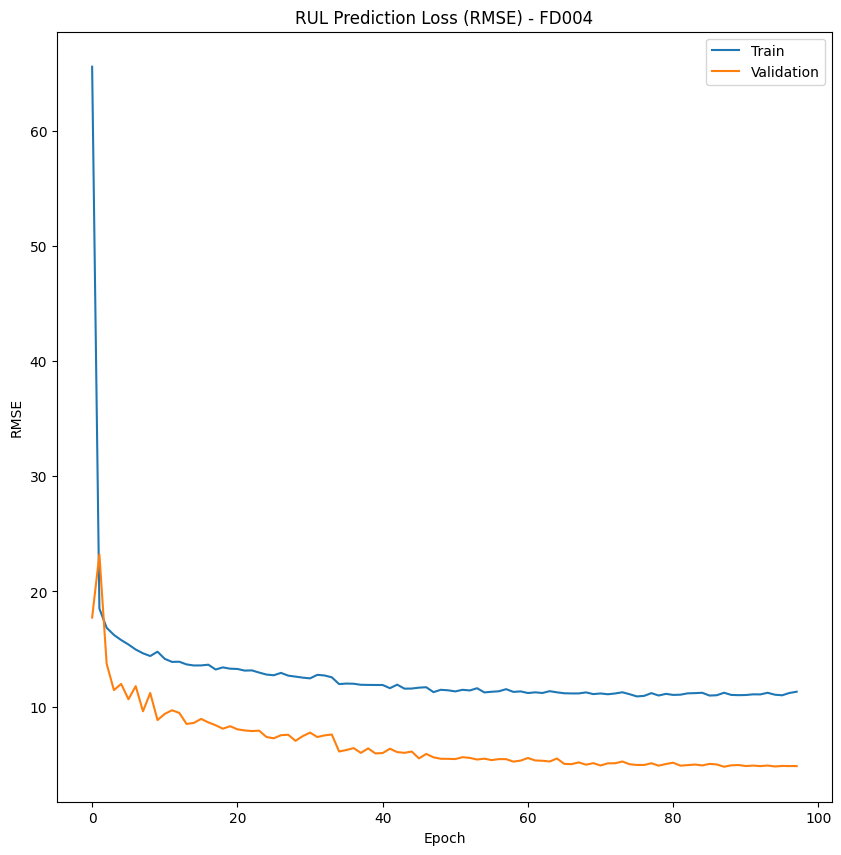

248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
Epoch 1/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 59s 28ms/step - loss: 6775.3872 - rmse: 81.8012 - val_loss: 405.6893 - val_rmse: 20.1417 - learning_rate: 0.0010
Epoch 2/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 376.4796 - rmse: 19.3823 - val_loss: 228.4957 - val_rmse: 15.1161 - learning_rate: 0.0010
Epoch 3/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 300.7516 - rmse: 17.3410 - val_loss: 199.8188 - val_rmse: 14.1357 - learning_rate: 0.0010
Epoch 4/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 279.9649 - rmse: 16.7312 - val_loss: 187.2493 - val_rmse: 13.6839 - learning_rate: 0.0010
Epoch 5/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 256.3124 - rmse: 16.0083 - val_loss: 129.9175 - val_rmse: 11.3981 - learning_rate: 0.0010
Epoch 6/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 238.2363 - rmse: 15.4329 - val_loss: 117.4326 - val_rmse: 10.8366 - learning_rate: 0.0010
Epoch 7/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/s

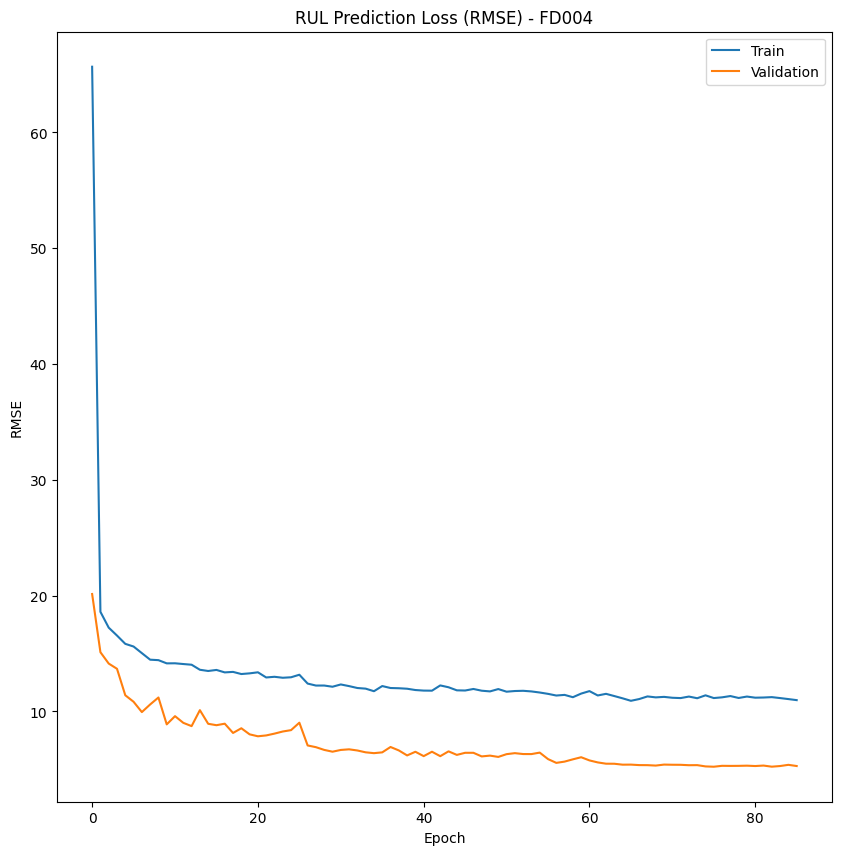

248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
Epoch 1/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 58s 28ms/step - loss: 6779.3691 - rmse: 81.8217 - val_loss: 306.7505 - val_rmse: 17.5143 - learning_rate: 0.0010
Epoch 2/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 382.3834 - rmse: 19.5298 - val_loss: 152.6339 - val_rmse: 12.3545 - learning_rate: 0.0010
Epoch 3/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 290.8926 - rmse: 17.0518 - val_loss: 135.3030 - val_rmse: 11.6320 - learning_rate: 0.0010
Epoch 4/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 267.7400 - rmse: 16.3616 - val_loss: 154.9398 - val_rmse: 12.4475 - learning_rate: 0.0010
Epoch 5/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 249.2067 - rmse: 15.7843 - val_loss: 100.5843 - val_rmse: 10.0292 - learning_rate: 0.0010
Epoch 6/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 231.1059 - rmse: 15.1989 - val_loss: 105.6361 - val_rmse: 10.2779 - learning_rate: 0.0010
Epoch 7/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/s

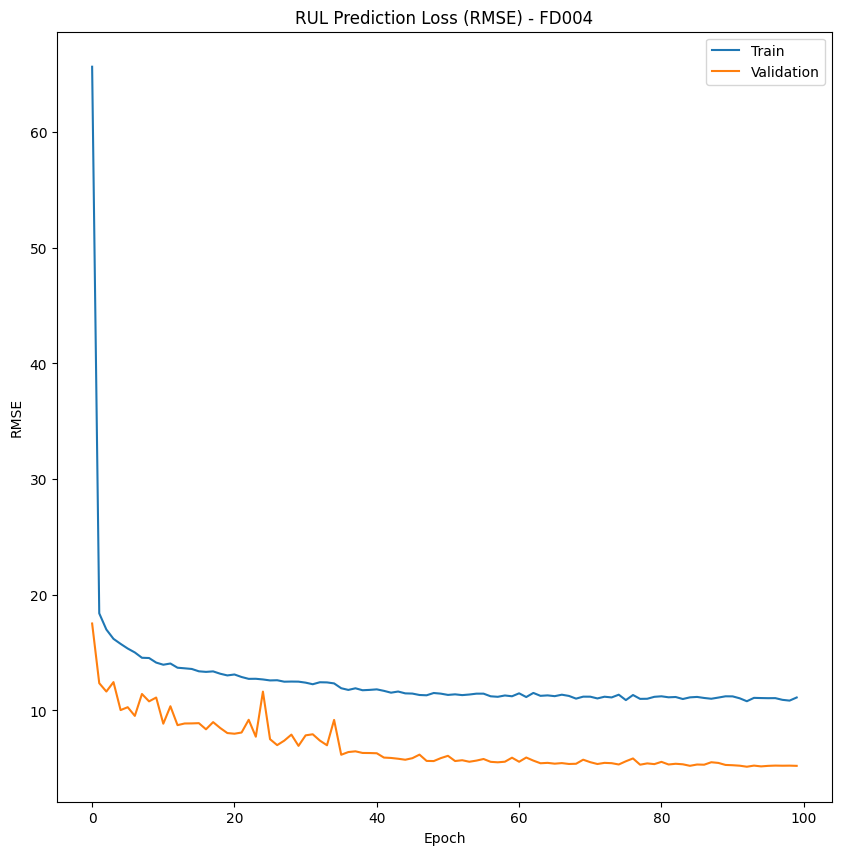

248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
Epoch 1/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 58s 28ms/step - loss: 6733.4497 - rmse: 81.5686 - val_loss: 326.2305 - val_rmse: 18.0619 - learning_rate: 0.0010
Epoch 2/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 371.9994 - rmse: 19.2660 - val_loss: 214.0546 - val_rmse: 14.6306 - learning_rate: 0.0010
Epoch 3/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 290.1120 - rmse: 17.0295 - val_loss: 6609.1646 - val_rmse: 81.2968 - learning_rate: 0.0010
Epoch 4/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 281.6748 - rmse: 16.7785 - val_loss: 190.7733 - val_rmse: 13.8121 - learning_rate: 0.0010
Epoch 5/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 247.4541 - rmse: 15.7297 - val_loss: 146.6730 - val_rmse: 12.1109 - learning_rate: 0.0010
Epoch 6/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 239.0300 - rmse: 15.4599 - val_loss: 140.8586 - val_rmse: 11.8684 - learning_rate: 0.0010
Epoch 7/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/

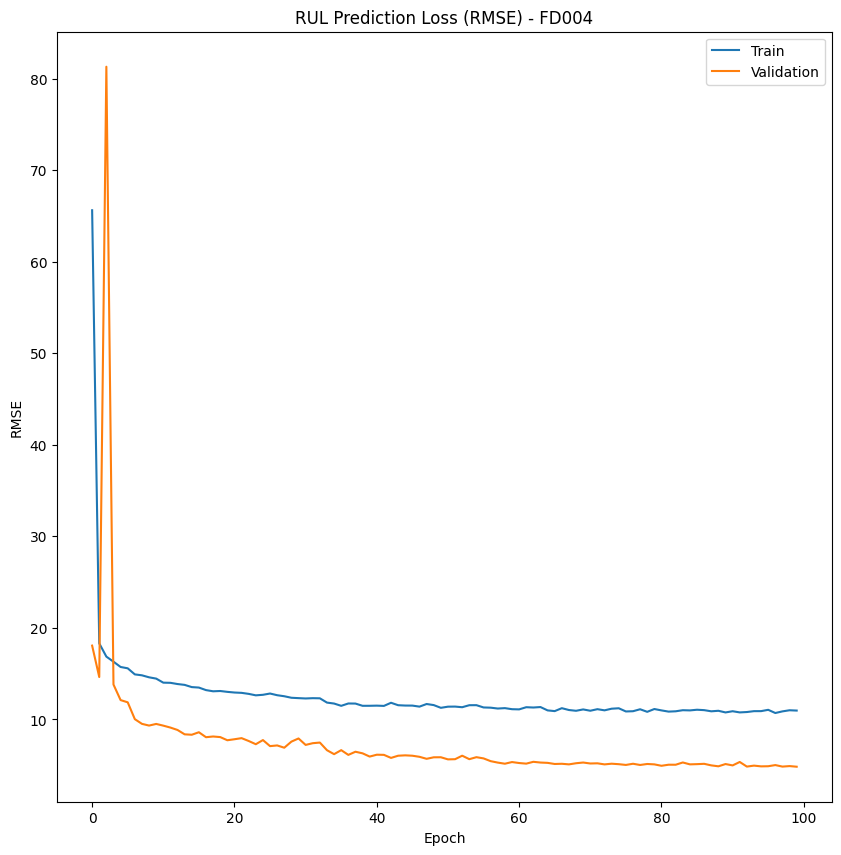

248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
Epoch 1/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 58s 27ms/step - loss: 6681.2876 - rmse: 81.2451 - val_loss: 327.6730 - val_rmse: 18.1017 - learning_rate: 0.0010
Epoch 2/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 370.7846 - rmse: 19.2289 - val_loss: 157.9398 - val_rmse: 12.5674 - learning_rate: 0.0010
Epoch 3/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 293.8210 - rmse: 17.1366 - val_loss: 145.9340 - val_rmse: 12.0803 - learning_rate: 0.0010
Epoch 4/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 266.2541 - rmse: 16.3153 - val_loss: 146.3580 - val_rmse: 12.0979 - learning_rate: 0.0010
Epoch 5/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 255.9655 - rmse: 15.9981 - val_loss: 139.3174 - val_rmse: 11.8033 - learning_rate: 0.0010
Epoch 6/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 234.0733 - rmse: 15.2983 - val_loss: 135.8035 - val_rmse: 11.6535 - learning_rate: 0.0010
Epoch 7/100
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/s

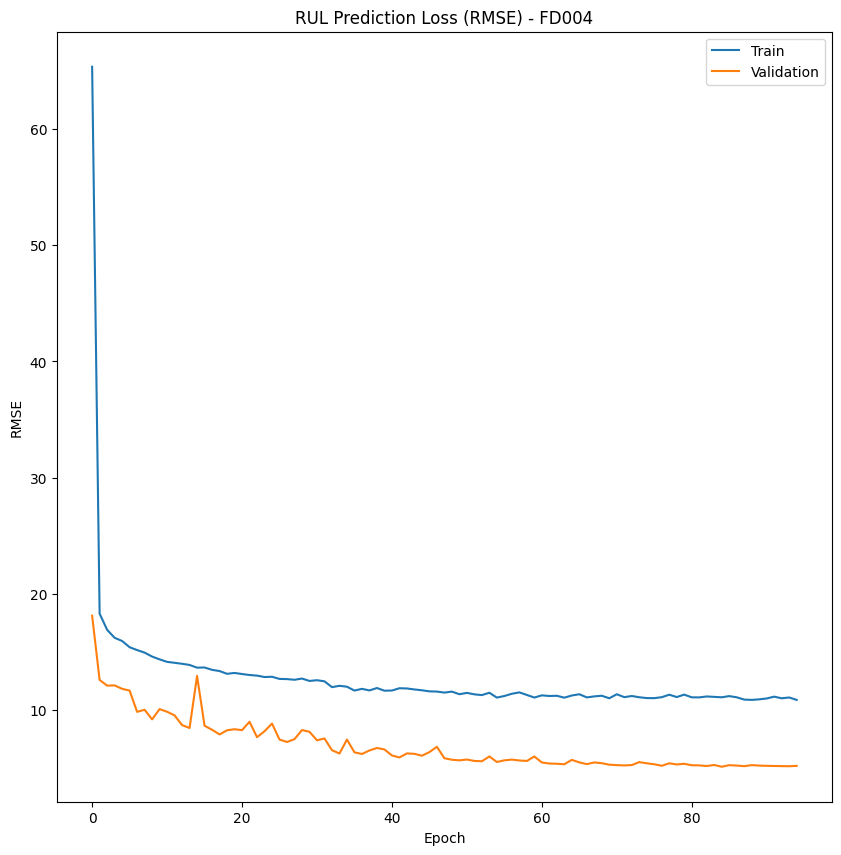

248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
Epoch 1/100
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 72s 33ms/step - loss: 6210.9180 - rmse: 77.9899 - val_loss: 192.1595 - val_rmse: 13.8622 - learning_rate: 0.0010
Epoch 2/100
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 304.1385 - rmse: 17.4388 - val_loss: 123.0324 - val_rmse: 11.0920 - learning_rate: 0.0010
Epoch 3/100
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 268.3512 - rmse: 16.3808 - val_loss: 199.7099 - val_rmse: 14.1319 - learning_rate: 0.0010
Epoch 4/100
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 260.2102 - rmse: 16.1241 - val_loss: 121.7711 - val_rmse: 11.0350 - learning_rate: 0.0010
Epoch 5/100
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 244.7054 - rmse: 15.6418 - val_loss: 122.4783 - val_rmse: 11.0670 - learning_rate: 0.0010
Epoch 6/100
1239/1239 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 226.6422 - rmse: 15.0522 - val_loss: 91.6000 - val_rmse: 9.5708 - learning_rate: 0.0010
Epoch 7/100
1239/1239 ━━━━━━━━━━━━

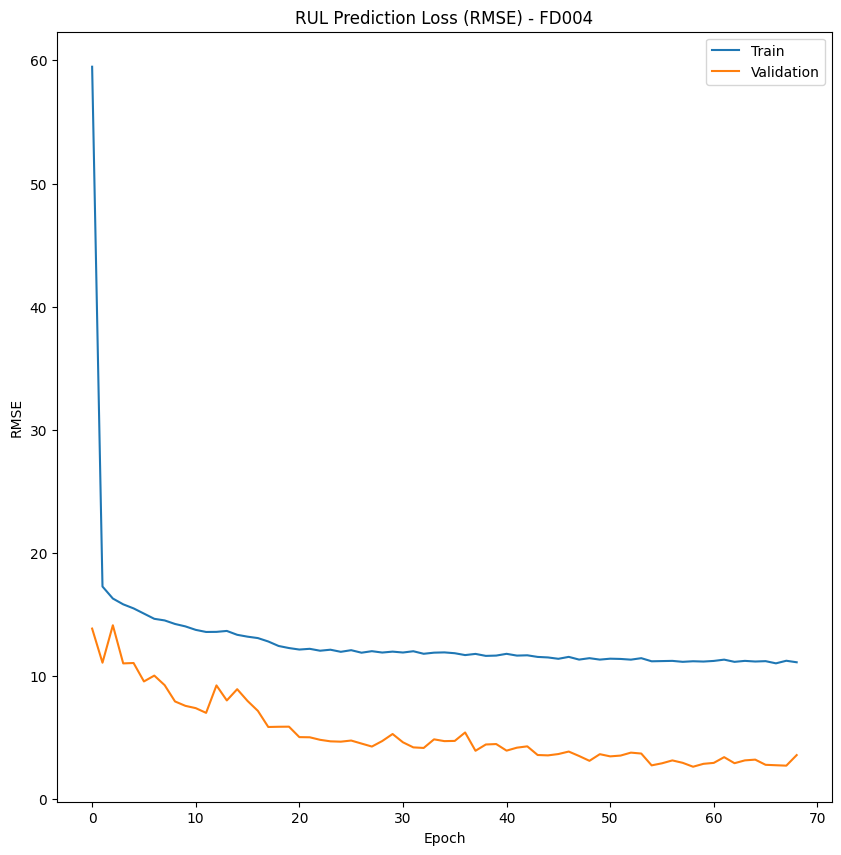

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 981ms/step


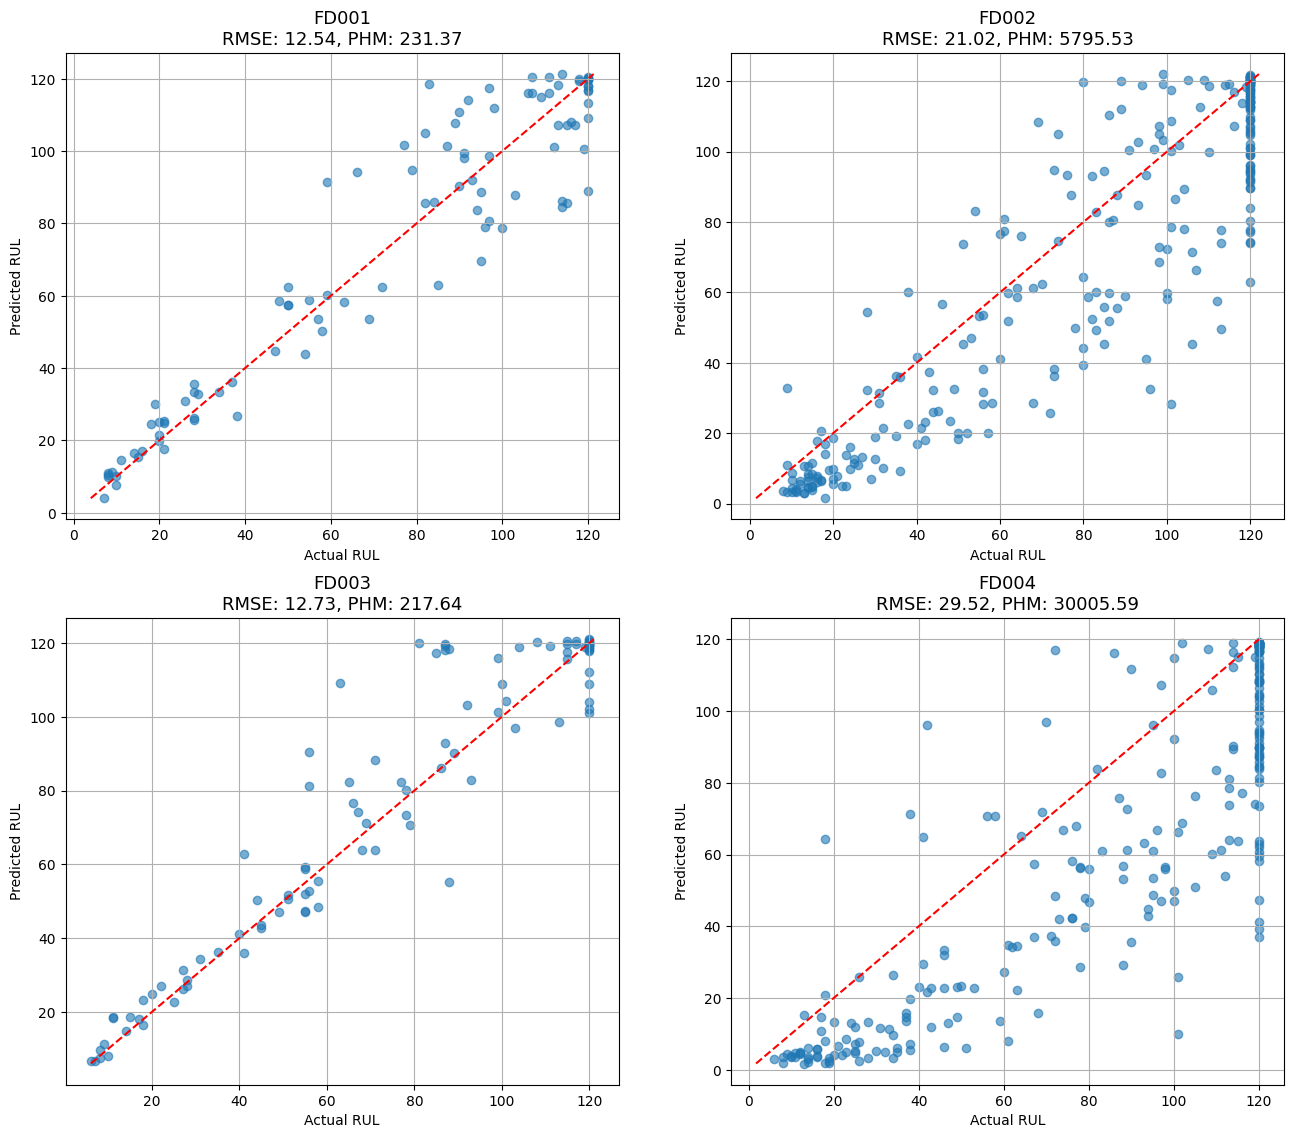

In [ ]:
# Run pipeline with MSE as eval metric during training
dataset_names = ["FD001", "FD002", "FD003", "FD004"]
results_pipeline = pipeline(dataset_names, f"{file_path}transformer/", loss='mse')
plot_dispersion_grid(results_pipeline, save_dir)

# **Effect of data augmentation**

## Data Augmentation Pipeline

In order to estimate how well our data augmentation procedure works, we use the newly created transformer model to train on augmented and non-augmented versions of all four datasets. This approach allows us to verify that data augmentation indeed increases the accuracy of our predictions and identify any potential shortcomings.

The pipeline is structured almost identically to the main pipeline, with minor adjustments to allow for the comparison of differently augmented versions of the datasets.

Note that, in order to make this estimation computationally feasible, we perform a simple train-val split instead of the 5-fold cross validation and train the models for smaller number of epochs.

In [ ]:
# ------------------------------
# Adjusting the training pipeline for data augmentation results
# ------------------------------

# Define augmentation levels
levels = ["none", "medium"]

# Change the pipeline function to be used on the augmented and non-augmented datasets
def pipeline(dataset_names, base_path, loss='mse'):
    results = {}

    for level in levels:
        print(f"Running pipeline for {level}")
        level_results = {}

        for name in dataset_names:
            # Determine correct filenames based on augmentation level
            # The augmented files are output by the preprocessing script as
            # FD001_X_augmented.npy, while the non-augmented ones are saved as
            # FD001_X.npy.
            if level == "none":
                x_filename = f"{name}_X.npy"
                y_filename = f"{name}_y.npy"
            else:  # level == "medium"
                x_filename = f"{name}_X_augmented.npy"
                y_filename = f"{name}_y_augmented.npy"

            # Load training/validation data
            X = np.load(os.path.join(base_path, x_filename))
            y = np.load(os.path.join(base_path, y_filename))

            # Load test data
            test_data = np.load(os.path.join(base_path, f'{name}_test_windows.npz'))

            # Train/val split
            X_train, X_val, y_train, y_val = train_test_split(
                X, y,
                test_size=0.2,
                random_state=42,
                stratify=np.floor(y / 10).astype(int)
            )

            print(f"[{level} - {name}] Train shape: {X_train.shape}, Val shape: {X_val.shape}")
            y_train[y_train >= 130] = 130

            # Train model
            input_shape = X_train.shape[1:]
            model = build_enhanced_dast_model(input_shape)
            history = compile_and_train(model, X_train, y_train, X_val, y_val,
                                        name=f"{level}_{name}", save_dir=save_dir, loss=loss)
            evaluation = evaluate_model(model, test_data,
                                        name=f"{level}_{name}", save_dir=save_dir)

            # Save metrics
            level_results[name] = {
                'RMSE': float(evaluation[0]),
                'PHM': float(evaluation[1])
            }

        results[level] = level_results

    # Save results for later use
    results_save_path = os.path.join(base_path, "results.json")
    with open(results_save_path, 'w') as f:
        json.dump(results, f, indent=4)

    print(f"Results saved to {results_save_path}")
    return results

Running pipeline for none
[none - FD001] Train shape: (2548, 50, 15), Val shape: (638, 50, 15)
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 51s 261ms/step - loss: 6581.7275 - rmse: 81.1235 - val_loss: 6889.1099 - val_rmse: 83.0007 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5929.9355 - rmse: 76.9878 - val_loss: 3039.7935 - val_rmse: 55.1343 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5488.0420 - rmse: 74.0646 - val_loss: 3614.7920 - val_rmse: 60.1231 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4706.9653 - rmse: 68.5932 - val_loss: 4016.3672 - val_rmse: 63.3748 - learning_rate: 0.0010
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3962.9888 - rmse: 62.9372 - val_loss: 4874.0620 - val_rmse: 69.8145 - learning_rate: 0.0010
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3370.3096 - rmse: 58.0342 - val_loss: 1244.3729 - val_rmse: 35.2757 - learning_rate: 0.0010
Ep

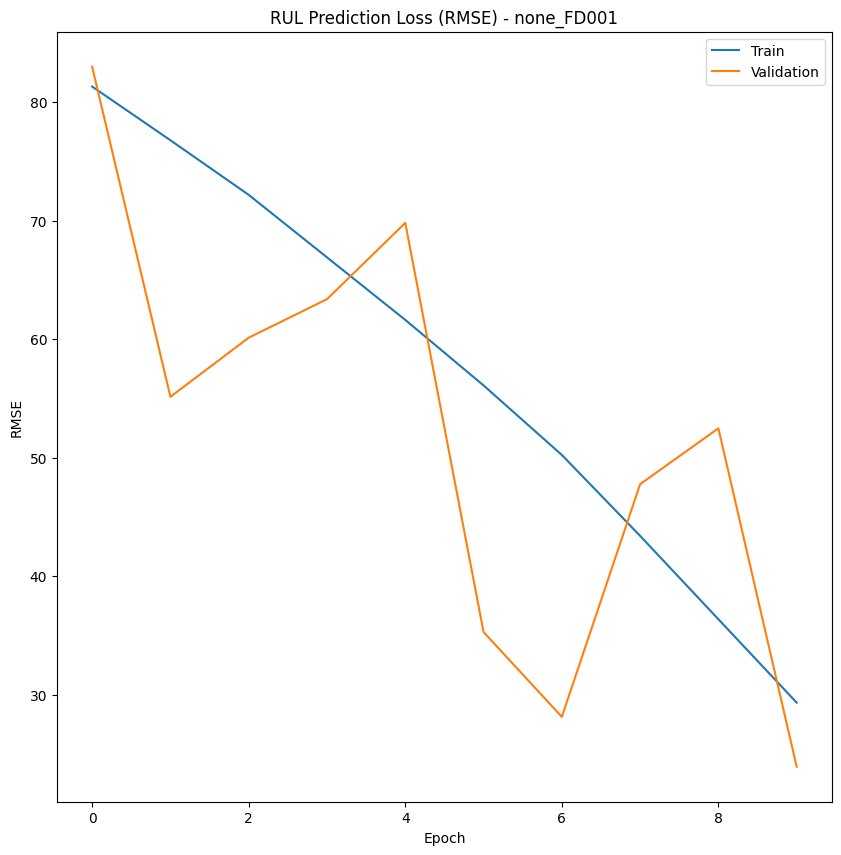

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 908ms/step
RMSE: 25.81
PHM Score: 1979.35


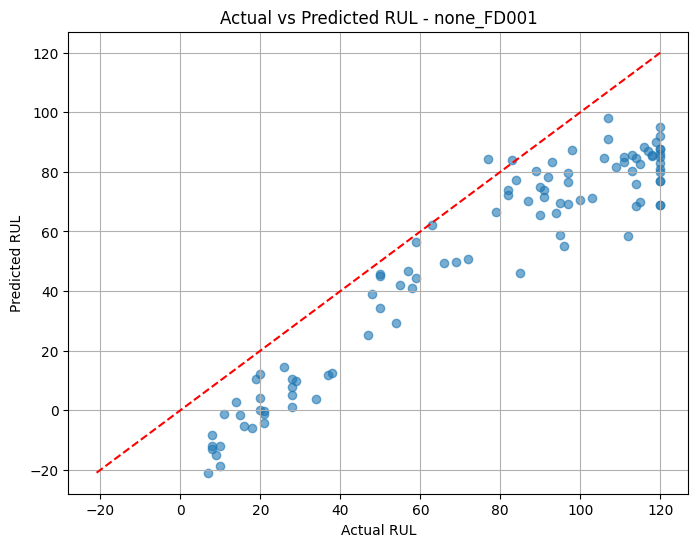

[none - FD002] Train shape: (6638, 50, 16), Val shape: (1660, 50, 16)
Epoch 1/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 52s 103ms/step - loss: 7960.9399 - rmse: 89.1945 - val_loss: 6630.6343 - val_rmse: 81.4287 - learning_rate: 0.0010
Epoch 2/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5883.0239 - rmse: 76.6677 - val_loss: 3929.0774 - val_rmse: 62.6824 - learning_rate: 0.0010
Epoch 3/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3812.4875 - rmse: 61.7012 - val_loss: 1770.4708 - val_rmse: 42.0770 - learning_rate: 0.0010
Epoch 4/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1888.4271 - rmse: 43.3201 - val_loss: 800.2799 - val_rmse: 28.2892 - learning_rate: 0.0010
Epoch 5/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 683.3557 - rmse: 26.0449 - val_loss: 404.0851 - val_rmse: 20.1019 - learning_rate: 0.0010
Epoch 6/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 330.0487 - rmse: 18.1621 - val_loss: 164.7298 - val_rmse: 12.8347 - learning_rate: 0.0010
Epoch 7/10
208/208 ━

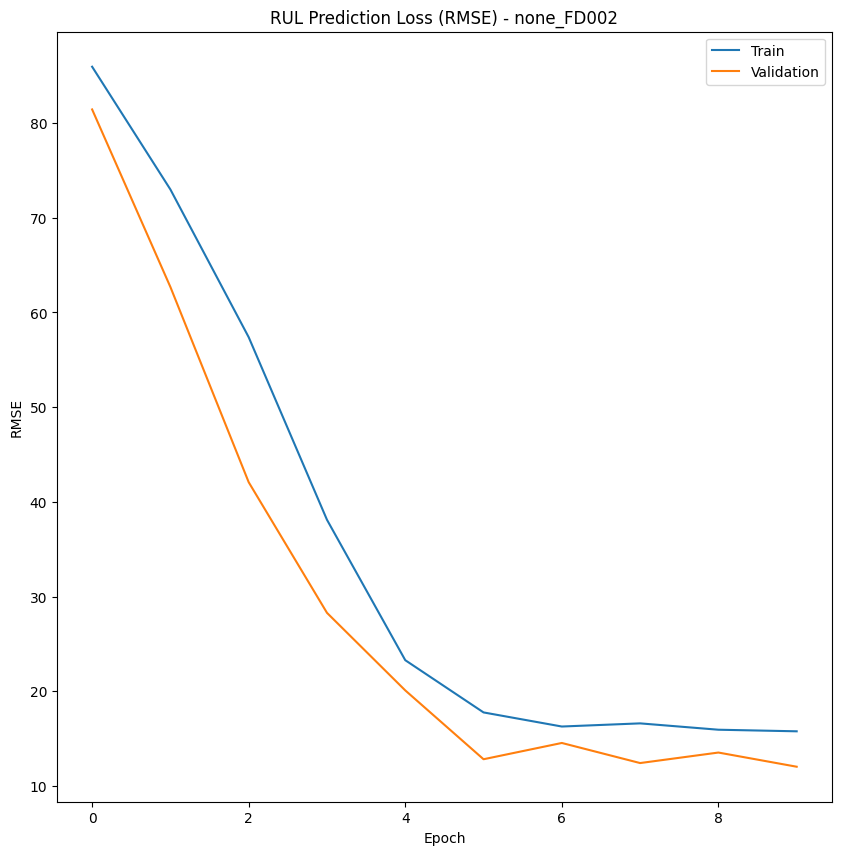

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step
RMSE: 21.86
PHM Score: 5461.58


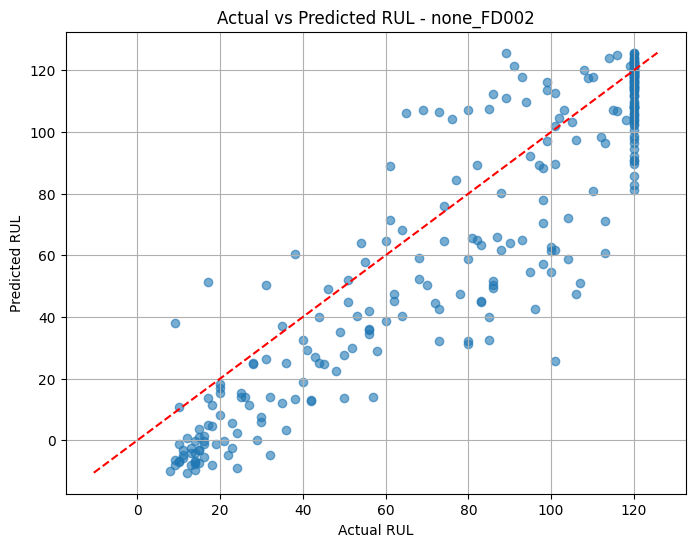

[none - FD003] Train shape: (3204, 50, 16), Val shape: (802, 50, 16)
Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 51s 202ms/step - loss: 8335.8652 - rmse: 91.2831 - val_loss: 5941.4390 - val_rmse: 77.0807 - learning_rate: 0.0010
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7284.2817 - rmse: 85.3287 - val_loss: 6184.2119 - val_rmse: 78.6398 - learning_rate: 0.0010
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6197.4102 - rmse: 78.7131 - val_loss: 4536.3271 - val_rmse: 67.3523 - learning_rate: 0.0010
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5078.3662 - rmse: 71.2179 - val_loss: 7222.0029 - val_rmse: 84.9824 - learning_rate: 0.0010
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4285.6333 - rmse: 65.4525 - val_loss: 2971.7769 - val_rmse: 54.5140 - learning_rate: 0.0010
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3317.3408 - rmse: 57.5575 - val_loss: 3053.7700 - val_rmse: 55.2609 - learning_rate: 0.0010
Epoch 7/10
101/1

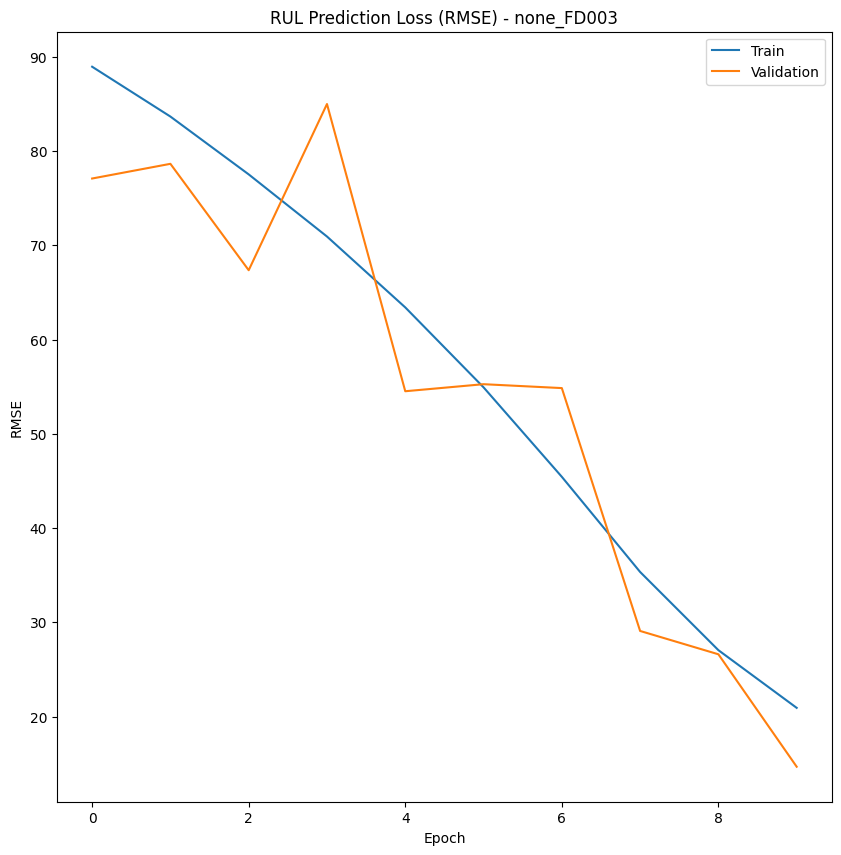

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 944ms/step
RMSE: 14.28
PHM Score: 329.60


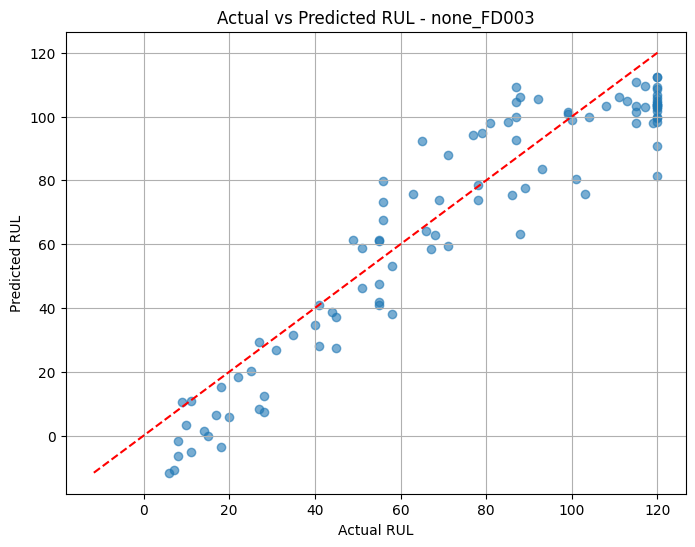

[none - FD004] Train shape: (7924, 50, 15), Val shape: (1981, 50, 15)
Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 52s 88ms/step - loss: 8629.4111 - rmse: 92.8689 - val_loss: 5964.3696 - val_rmse: 77.2293 - learning_rate: 0.0010
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6208.1577 - rmse: 78.7408 - val_loss: 6265.9399 - val_rmse: 79.1577 - learning_rate: 0.0010
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3460.3684 - rmse: 58.7166 - val_loss: 1559.0250 - val_rmse: 39.4845 - learning_rate: 0.0010
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1220.3451 - rmse: 34.8181 - val_loss: 711.5171 - val_rmse: 26.6743 - learning_rate: 0.0010
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 417.8347 - rmse: 20.4345 - val_loss: 149.3266 - val_rmse: 12.2199 - learning_rate: 0.0010
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 307.0898 - rmse: 17.5203 - val_loss: 156.6191 - val_rmse: 12.5148 - learning_rate: 0.0010
Epoch 7/10
248/248 ━━

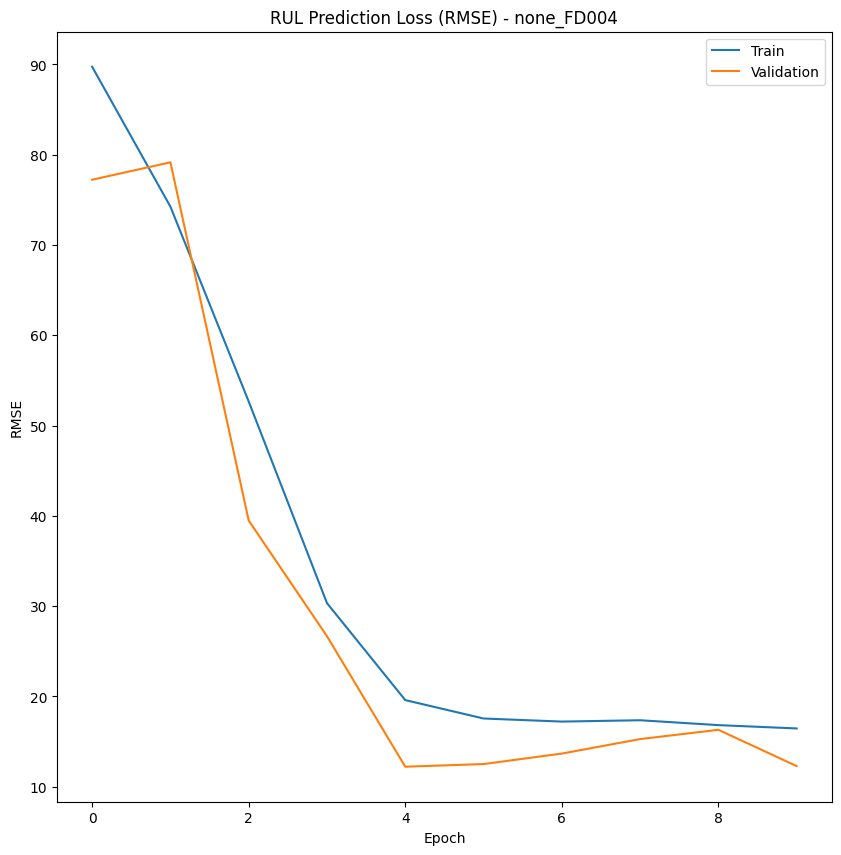

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step
RMSE: 29.96
PHM Score: 34153.96


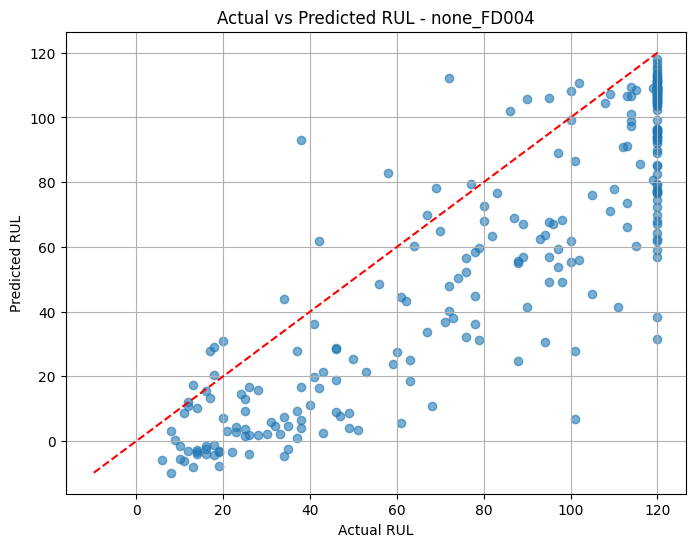

Running pipeline for medium
[medium - FD001] Train shape: (10195, 50, 15), Val shape: (2549, 50, 15)
Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 62s 74ms/step - loss: 6238.5498 - rmse: 78.9508 - val_loss: 4368.5259 - val_rmse: 66.0948 - learning_rate: 0.0010
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3519.4580 - rmse: 59.2346 - val_loss: 1358.8485 - val_rmse: 36.8626 - learning_rate: 0.0010
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1146.5862 - rmse: 33.7295 - val_loss: 635.8002 - val_rmse: 25.2151 - learning_rate: 0.0010
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 288.8192 - rmse: 16.9862 - val_loss: 111.1320 - val_rmse: 10.5419 - learning_rate: 0.0010
Epoch 5/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 224.7023 - rmse: 14.9852 - val_loss: 127.7759 - val_rmse: 11.3038 - learning_rate: 0.0010
Epoch 6/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 203.7085 - rmse: 14.2710 - val_loss: 91.8732 - val_rmse: 9.5850 - learning_rate: 0

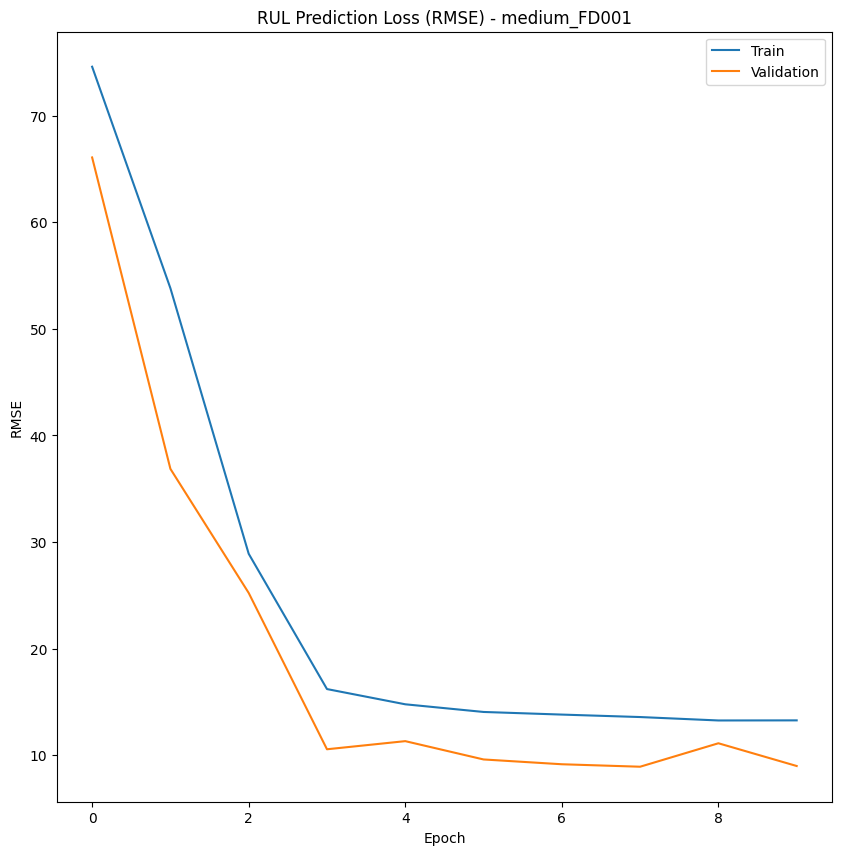

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 939ms/step
RMSE: 14.04
PHM Score: 349.96


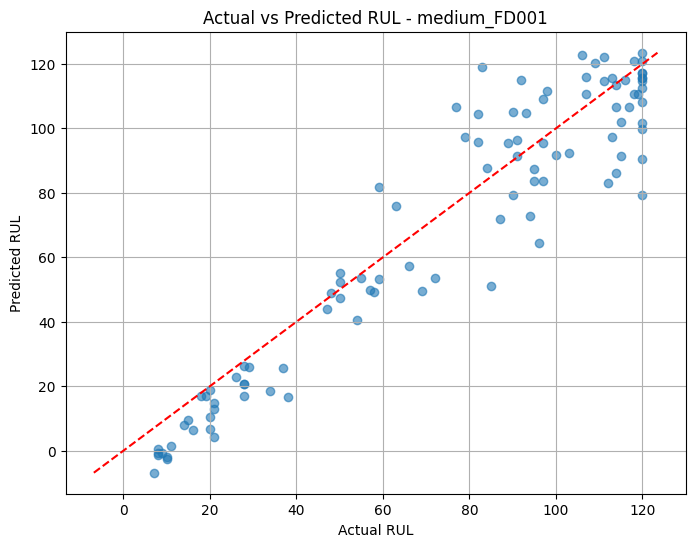

[medium - FD002] Train shape: (26553, 50, 16), Val shape: (6639, 50, 16)
Epoch 1/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 58s 33ms/step - loss: 6354.3467 - rmse: 79.3715 - val_loss: 648.3724 - val_rmse: 25.4632 - learning_rate: 0.0010
Epoch 2/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 491.4525 - rmse: 22.0225 - val_loss: 155.8057 - val_rmse: 12.4822 - learning_rate: 0.0010
Epoch 3/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 278.4655 - rmse: 16.6867 - val_loss: 124.0256 - val_rmse: 11.1367 - learning_rate: 0.0010
Epoch 4/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 258.5730 - rmse: 16.0792 - val_loss: 114.9923 - val_rmse: 10.7234 - learning_rate: 0.0010
Epoch 5/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 235.6640 - rmse: 15.3490 - val_loss: 118.5592 - val_rmse: 10.8885 - learning_rate: 0.0010
Epoch 6/10
830/830 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 223.0829 - rmse: 14.9348 - val_loss: 107.1452 - val_rmse: 10.3511 - learning_rate: 0.0010
Epoch 7/10
830/830 ━━━━━

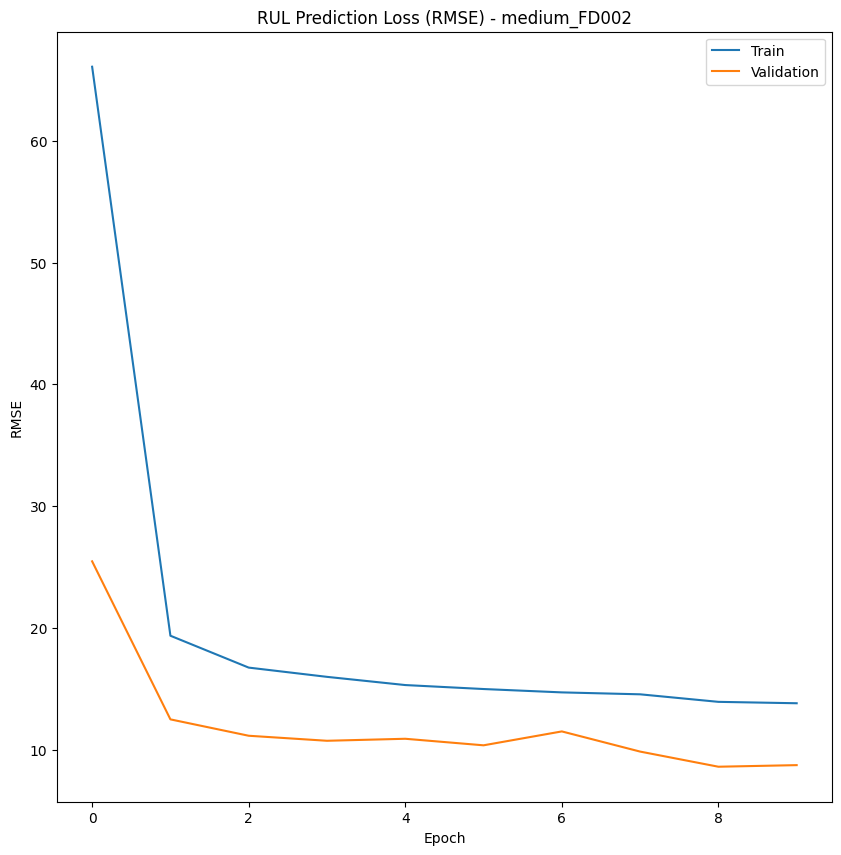

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 346ms/step
RMSE: 20.82
PHM Score: 5813.26


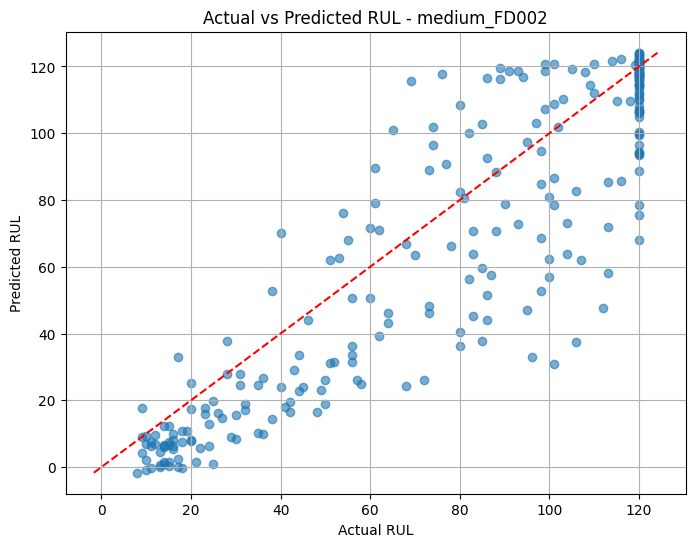

[medium - FD003] Train shape: (12819, 50, 16), Val shape: (3205, 50, 16)
Epoch 1/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 54s 58ms/step - loss: 7490.1157 - rmse: 86.4829 - val_loss: 2910.6719 - val_rmse: 53.9506 - learning_rate: 0.0010
Epoch 2/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3590.1077 - rmse: 59.6818 - val_loss: 879.3199 - val_rmse: 29.6533 - learning_rate: 0.0010
Epoch 3/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 646.3370 - rmse: 25.2417 - val_loss: 891.3878 - val_rmse: 29.8561 - learning_rate: 0.0010
Epoch 4/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 232.3074 - rmse: 15.2373 - val_loss: 95.0557 - val_rmse: 9.7497 - learning_rate: 0.0010
Epoch 5/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 219.3471 - rmse: 14.8084 - val_loss: 91.0248 - val_rmse: 9.5407 - learning_rate: 0.0010
Epoch 6/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 204.5115 - rmse: 14.2995 - val_loss: 70.8307 - val_rmse: 8.4161 - learning_rate: 0.0010
Epoch 7/10
401/401 ━━━━━━━━━

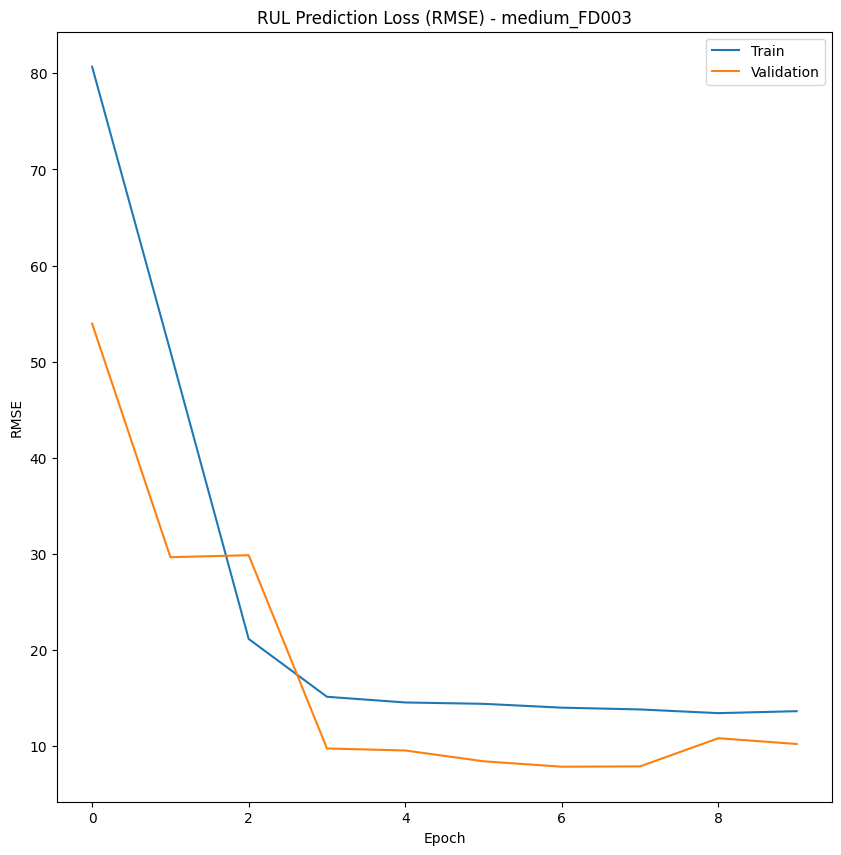

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 922ms/step
RMSE: 12.58
PHM Score: 318.47


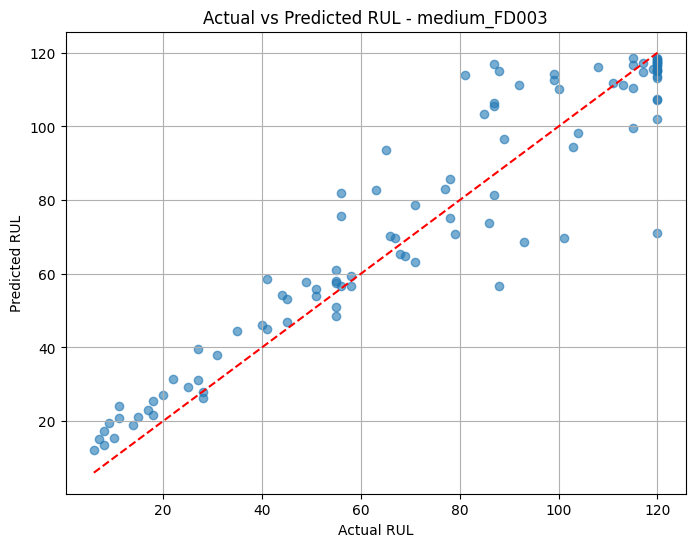

[medium - FD004] Train shape: (31696, 50, 15), Val shape: (7924, 50, 15)
Epoch 1/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 58s 27ms/step - loss: 6744.7705 - rmse: 81.6247 - val_loss: 297.1791 - val_rmse: 17.2389 - learning_rate: 0.0010
Epoch 2/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 354.3683 - rmse: 18.8066 - val_loss: 168.9652 - val_rmse: 12.9987 - learning_rate: 0.0010
Epoch 3/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 288.0755 - rmse: 16.9704 - val_loss: 125.2784 - val_rmse: 11.1928 - learning_rate: 0.0010
Epoch 4/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 261.5398 - rmse: 16.1712 - val_loss: 133.2989 - val_rmse: 11.5455 - learning_rate: 0.0010
Epoch 5/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 256.9304 - rmse: 16.0268 - val_loss: 117.3017 - val_rmse: 10.8306 - learning_rate: 0.0010
Epoch 6/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 232.3678 - rmse: 15.2424 - val_loss: 149.4656 - val_rmse: 12.2256 - learning_rate: 0.0010
Epoch 7/10
991/991 ━━━━━

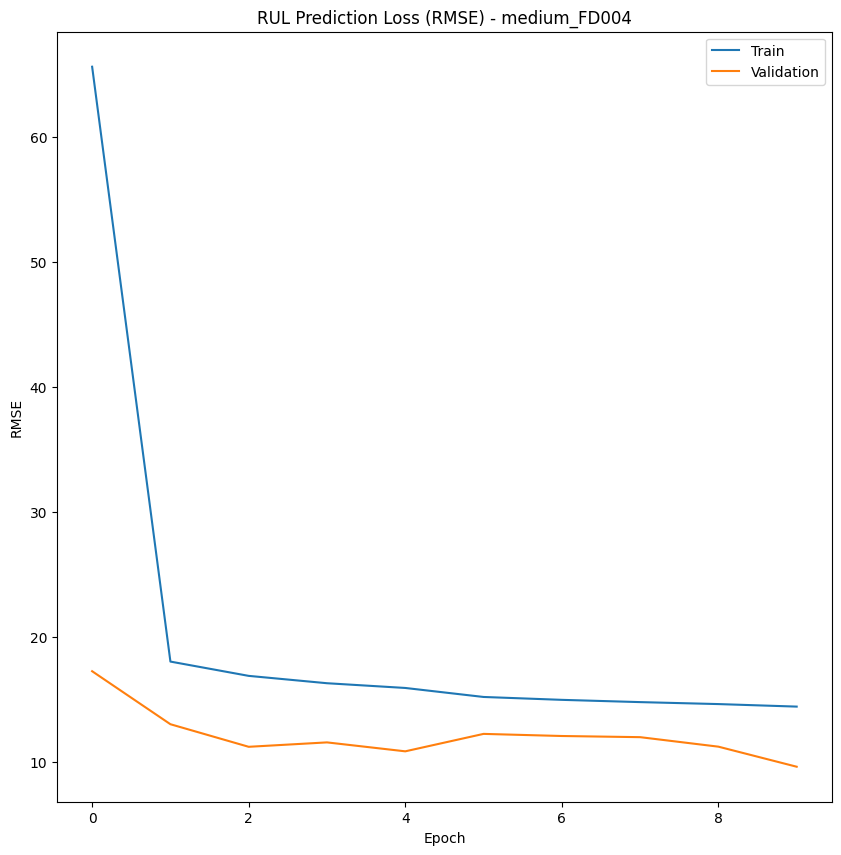

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 410ms/step
RMSE: 33.71
PHM Score: 69546.94


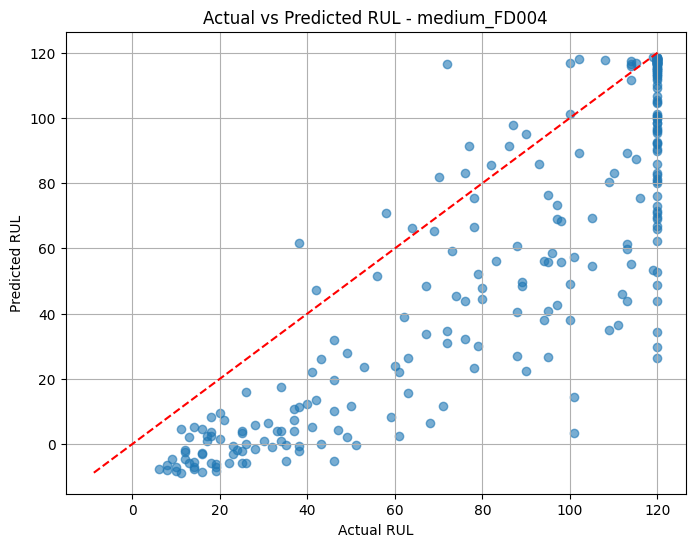

Results saved to /content/drive/MyDrive/Colab Notebooks/I Learn Deep/tensors/transformer/results.json


In [ ]:
dataset_names = ["FD001", "FD002", "FD003", "FD004"]
n_epochs = 10

base_path_50 = f'{file_path}transformer/'
results = pipeline(dataset_names, base_path_50, loss='mse')

## Data Augmentation Results

This final section defines a function for visualizing the results of the data augmentation. We therefore plot RMSE and PHM Score for each dataset variation and compare them side by side.

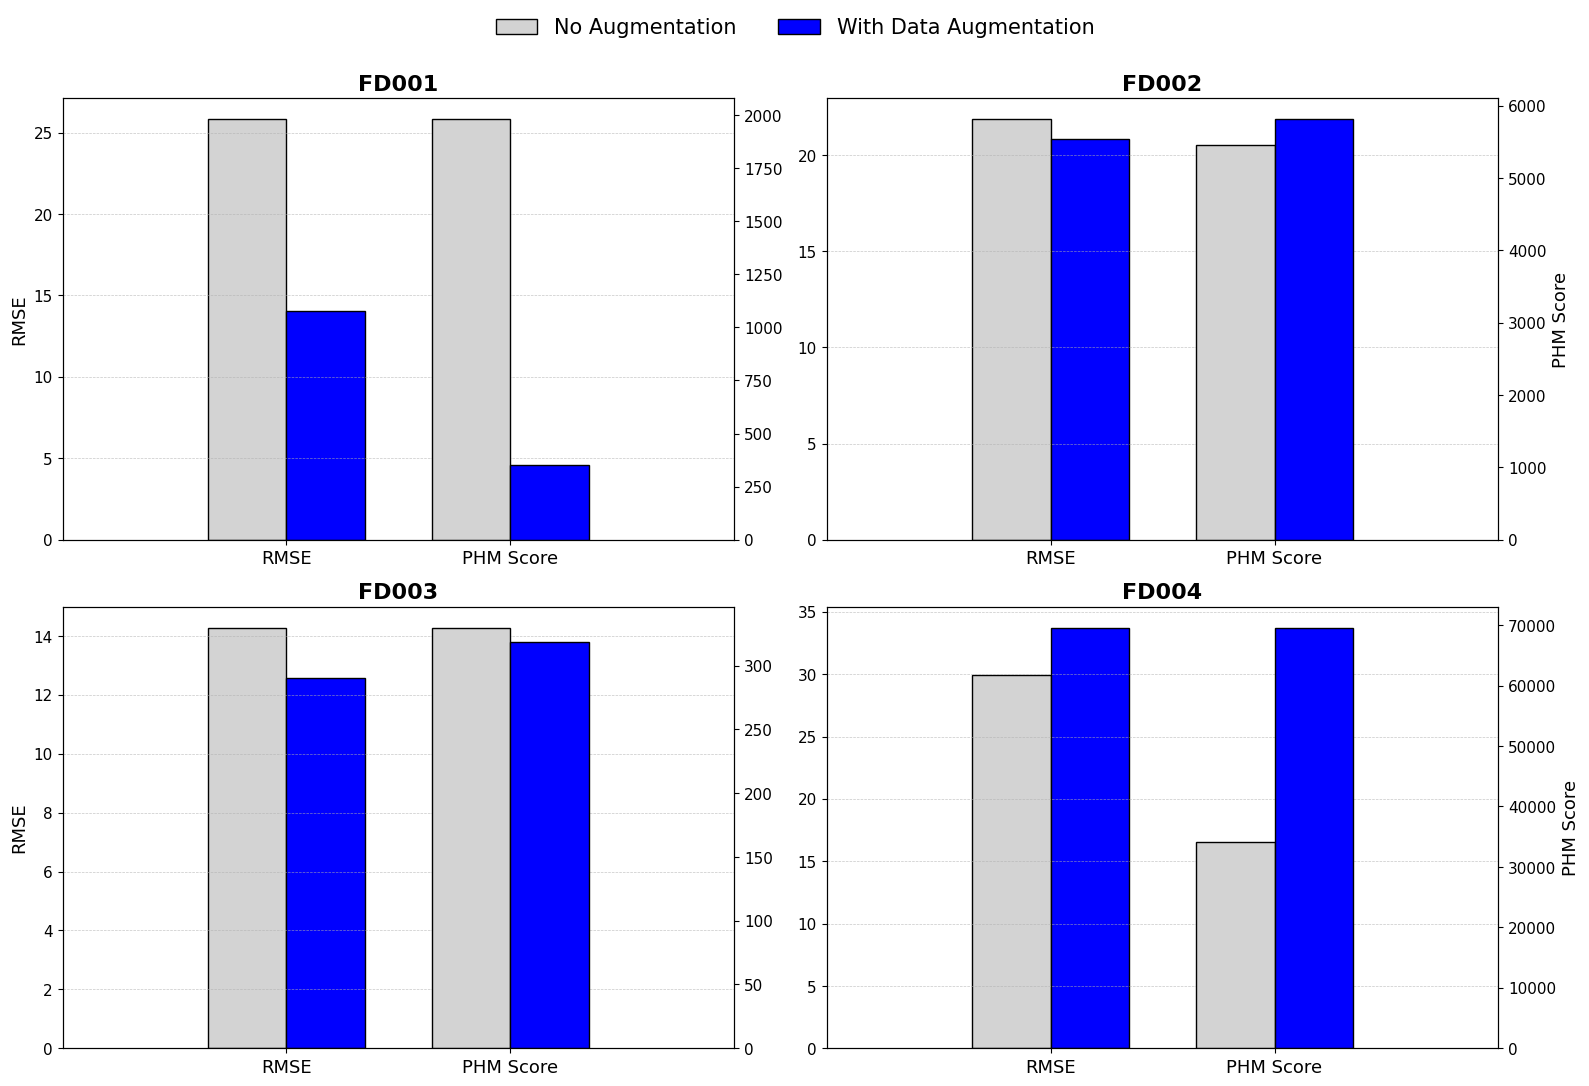

In [ ]:
# ------------------------------
# Data augmentation results visualization
# ------------------------------

def plot_all_results(results):
    datasets = ['FD001', 'FD002', 'FD003', 'FD004']
    levels = list(results.keys())  # ["none", "medium"]

    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    fig.subplots_adjust(top=0.83)

    colors = {'none': 'lightgrey', 'medium': 'blue'}

    handles = []
    labels = []

    for idx, dataset_name in enumerate(datasets):
        ax = axs[idx // 2, idx % 2]
        ax2 = ax.twinx()

        rmse_none = results['none'][dataset_name]['RMSE']
        rmse_medium = results['medium'][dataset_name]['RMSE']
        score_none = results['none'][dataset_name]['PHM']
        score_medium = results['medium'][dataset_name]['PHM']

        x_rmse = np.array([0])
        x_score = np.array([1])
        width = 0.35

        # RMSE bars
        bars1 = ax.bar(x_rmse - width/2, rmse_none, width, color=colors['none'], edgecolor='black', label='No Aug')
        bars2 = ax.bar(x_rmse + width/2, rmse_medium, width, color=colors['medium'], edgecolor='black', label='Medium Aug')
        ax.tick_params(axis='y', labelsize=11)

        # PHM Score bars
        bars3 = ax2.bar(x_score - width/2, score_none, width, color=colors['none'], edgecolor='black')
        bars4 = ax2.bar(x_score + width/2, score_medium, width, color=colors['medium'], edgecolor='black')
        ax2.tick_params(axis='y', labelsize=11)

        # Axis labels conditionally (to be able to move the plots closer to each other
        # and save some space in the report)

        if idx % 2 == 0:  # Left column (0 and 2)
            ax.set_ylabel('RMSE', fontsize=13)
        else:  # Right column (1 and 3)
            ax2.set_ylabel('PHM Score', fontsize=13)

        if idx == 0:
            handles = [bars1, bars2]
            labels = ['No Augmentation', 'With Data Augmentation']

        ax.set_xticks([0, 1])
        ax.set_xticklabels(['RMSE', 'PHM Score'], fontsize=13)
        ax.set_xlim(-1, 2)
        ax.set_title(dataset_name, fontsize=16, fontweight='bold')
        ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

    # Global Legend for all four plots
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.91), ncol=2, fontsize=15, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.86])
    plt.show()
    fig.savefig('augmentation_results.png', dpi=300, bbox_inches='tight')

# Produce the final plot
plot_all_results(results)